# TP 4 : données manquantes, détection d'outliers, prédiction de RUL

Dans ce TP, nous travaillerons avec le même genre de données que précédemment, mais cette fois-ci, elles auront été dégradées pour traiter les problématiques proposées.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ANR.csv to ANR.csv


In [3]:
import pathlib
import numpy as np
import pandas as pd

In [4]:
# Vous trouverez ici les données du TP
filedir = pathlib.Path('data/TP4_inputs')
files = list(filedir.glob('*.csv'))
print(files)

[PosixPath('data/TP4_inputs/HGH.csv'), PosixPath('data/TP4_inputs/FOG.csv'), PosixPath('data/TP4_inputs/ANR.csv')]


# 1 Gestion des données manquantes


1.1. lire les fichiers avec pandas et les concatener. (5'/5')

In [5]:
# Réponse
df_data = pd.concat((pd.read_csv(filename, sep=',', na_filter=True) for filename in files), ignore_index=True, axis=0)
df_data.head()

,AC_REG,CYCLE,TEMP_C°,HUMID_REL_PC(%),THRUST_PC(%),S0D_TMP_SN,S0D_TMP_S2N,S0D_FLP_S3N,S0D_TMP_S4N,S0D_WHL_S5N,...,S2D_PRS_S1N,S1D_TMP_S43N,S34D_TMP_SN,S2D_PGHS_S1N,S0D_RRP_S2N,HOP_FLP_S7N,TEMP_N21,TEMP_N23,TEMP_N32,Company
0,2,1,0.0017,0.0006,100%,518.67,641.59,1578.61,1401.71,"14,62",...,23.4589,0.0,GGH,PPO,0.0,99.0,120.604546,87.097724,0.431706,HGH
1,2,2,35.0026,0.8405,60%,449.44,554.68,1357.66,1117.74,"5,48",...,8.9947,0.0,FLO,PPO,99.0,6.0,1.028685,1.405675,16.112031,HGH
2,2,3,42.0011,0.8400,40%,445.0,548.63,1347.31,1118.90,"3,91",...,6.383,0.0,FLO,PPO,99.0,6.0,1.543027,2.108512,1.295118,HGH
3,2,4,42.0003,0.8407,40%,445.0,548.88,1350.73,1125.61,"3,91",...,6.3872,0.0,FLO,PPO,99.0,6.0,120.604546,2.811350,1.726823,HGH
4,2,5,20.0023,0.7000,0%,491.19,606.99,1477.32,1237.14,"9,35",...,14.8277,0.0,FLO,PPO,0.0,99.0,2.571712,87.097724,16.112031,HGH


 1.2 Affichez les types des variables du DataFrame et quelques valeurs. Que constatez-vous ? (5'/10')

In [6]:
for k in df_data.keys():
    print(df_data[k].iloc[0:3])

0    2
1    2
2    2
Name: AC_REG, dtype: int64
0    1
1    2
2    3
Name: CYCLE, dtype: int64
0     0.0017
1    35.0026
2    42.0011
Name: TEMP_C°, dtype: float64
0    0.0006
1    0.8405
2    0.8400
Name: HUMID_REL_PC(%), dtype: float64
0    100%
1     60%
2     40%
Name: THRUST_PC(%), dtype: object
0    518.67
1    449.44
2     445.0
Name: S0D_TMP_SN, dtype: object
0    641.59
1    554.68
2    548.63
Name: S0D_TMP_S2N, dtype: float64
0    1578.61
1    1357.66
2    1347.31
Name: S0D_FLP_S3N, dtype: float64
0    1401.71
1    1117.74
2    1118.90
Name: S0D_TMP_S4N, dtype: float64
0    14,62
1     5,48
2     3,91
Name: S0D_WHL_S5N, dtype: object
0    21.61
1     8.00
2     5.71
Name: S0D_WHL_S6N, dtype: float64
0    554.17
1     195.6
2    138.81
Name: S0D_FLP_S7N, dtype: object
0    2387.96
1    2223.03
2    2212.03
Name: S0D_WHL_S8N, dtype: float64
0    9056.88
1    8343.21
2    8322.02
Name: S0D_WHL_S9N, dtype: float64
0     1,3
1    1,02
2    1,02
Name: S1D_TMP_S0N, dtype: object
0  

1.3 Etablisser un dictionnaire des valeurs qui vous semblent devoir être équivalente à NaN. Remplacez les par `np.nan` pour faciliter les traitements.
Vous pouvez faire l'hypothèse que les NaN ne commencent pas par un chiffre. (5'/15')

In [7]:
# Réponse
uniques = set([
    str(value)
    for f in list(df_data)
    for value in df_data[f].unique()
    if str(value)[0] not in '0123456789'
])

print('candidats :', uniques)
na_dict = ['...',
    '/',
    'na',
    'nan',
    'no data'
]
print('filtrage manuel : ', na_dict)

candidats : {'FOG', 'no data', 'PPO', 'HGH', '/', 'FLO', 'GGH', '-99999.0', '...', 'na', 'ANR', 'nan', 'AAD'}
filtrage manuel :  ['...', '/', 'na', 'nan', 'no data']


Les experts métiers nous renseignent que les colonnes suivantes sont numériques :
````python
[
    'AC_REG',
     'CYCLE',
     'TEMP_C°',
     'HUMID_REL_PC(%)',
     'THRUST_PC(%)',
     'S0D_TMP_SN',
     'S0D_TMP_S2N',
     'S0D_FLP_S3N',
     'S0D_TMP_S4N',
     'S0D_WHL_S5N',
     'S0D_WHL_S6N',
     'S0D_FLP_S7N',
     'S0D_WHL_S8N',
     'S0D_WHL_S9N',
     'S1D_TMP_S0N',
     'S1D_TMP_S1N',
     'S1D_FLP_S2N',
     'S1D_FLP_S3N',
     'S1D_TMP_S4N',
     'S1D_PRS_S5N',
     'S1D_PRS_S6N',
     'S1D_TMP_S7N',
     'S1D_TMP_S8N',
     'S1D_TMP_S9N',
     'S2D_PRS_S0N',
     'S2D_PRS_S1N',
     'TEMP_N21',
     'TEMP_N23',
     'TEMP_N32'
]
````
1.4 Utilisez cette connaissance pour corriger les problèmes de types dans le jeu de données. (5'/20')

In [8]:
# Réponse
df_data["S1D_TMP_S0N"] = df_data["S1D_TMP_S0N"].str.replace(',', '.')
df_data["S0D_WHL_S5N"] = df_data["S0D_WHL_S5N"].str.replace(',', '.')
df_data["THRUST_PC(%)"] = df_data["THRUST_PC(%)"].str.replace('%', '')

for f in [
    'AC_REG',
     'CYCLE',
     'TEMP_C°',
     'HUMID_REL_PC(%)',
     'THRUST_PC(%)',
     'S0D_TMP_SN',
     'S0D_TMP_S2N',
     'S0D_FLP_S3N',
     'S0D_TMP_S4N',
     'S0D_WHL_S5N',
     'S0D_WHL_S6N',
     'S0D_FLP_S7N',
     'S0D_WHL_S8N',
     'S0D_WHL_S9N',
     'S1D_TMP_S0N',
     'S1D_TMP_S1N',
     'S1D_FLP_S2N',
     'S1D_FLP_S3N',
     'S1D_TMP_S4N',
     'S1D_PRS_S5N',
     'S1D_PRS_S6N',
     'S1D_TMP_S7N',
     'S1D_TMP_S8N',
     'S1D_TMP_S9N',
     'S2D_PRS_S0N',
     'S2D_PRS_S1N',
     'TEMP_N21',
     'TEMP_N23',
     'TEMP_N32'
]:
    df_data[f] = df_data[f].replace(na_dict, np.nan).astype(float)

df_data.keys()

Index(['AC_REG', 'CYCLE', 'TEMP_C°', 'HUMID_REL_PC(%)', 'THRUST_PC(%)',
       'S0D_TMP_SN', 'S0D_TMP_S2N', 'S0D_FLP_S3N', 'S0D_TMP_S4N',
       'S0D_WHL_S5N', 'S0D_WHL_S6N', 'S0D_FLP_S7N', 'S0D_WHL_S8N',
       'S0D_WHL_S9N', 'S1D_TMP_S0N', 'S1D_TMP_S1N', 'S1D_FLP_S2N',
       'S1D_FLP_S3N', 'S1D_TMP_S4N', 'S1D_PRS_S5N', 'S1D_PRS_S6N',
       'S1D_TMP_S7N', 'S1D_TMP_S8N', 'S1D_TMP_S9N', 'S2D_PRS_S0N',
       'S2D_PRS_S1N', 'S1D_TMP_S43N', 'S34D_TMP_SN', 'S2D_PGHS_S1N',
       'S0D_RRP_S2N', 'HOP_FLP_S7N', 'TEMP_N21', 'TEMP_N23', 'TEMP_N32',
       'Company'],
      dtype='object')

In [9]:
uniques = set([
    str(value)
    for f in list(df_data)
    for value in df_data[f].unique()
    if str(value)[0] not in '0123456789'
])

print('verification:', uniques)

verification: {'FOG', 'PPO', 'HGH', 'FLO', 'GGH', '-99999.0', 'ANR', 'nan', 'AAD'}


1.5 Visualisez la fréquence des données manquantes, commentez. (5'/25')

In [10]:
#Réponse
pd.DataFrame(df_data.isna().mean())

,0
AC_REG,0.000000
CYCLE,0.000000
TEMP_C°,0.000000
HUMID_REL_PC(%),0.000000
THRUST_PC(%),0.000000
S0D_TMP_SN,0.015132
S0D_TMP_S2N,0.013414
S0D_FLP_S3N,0.014945
S0D_TMP_S4N,0.013974
S0D_WHL_S5N,0.019354


In [11]:
print(df_data.isna().mean().max())

0.021371992228366464


1.6 Visualisez la position des Nans en utilisant le paquet missingno. Que voyez vous ? (5'/30')

<Axes: >

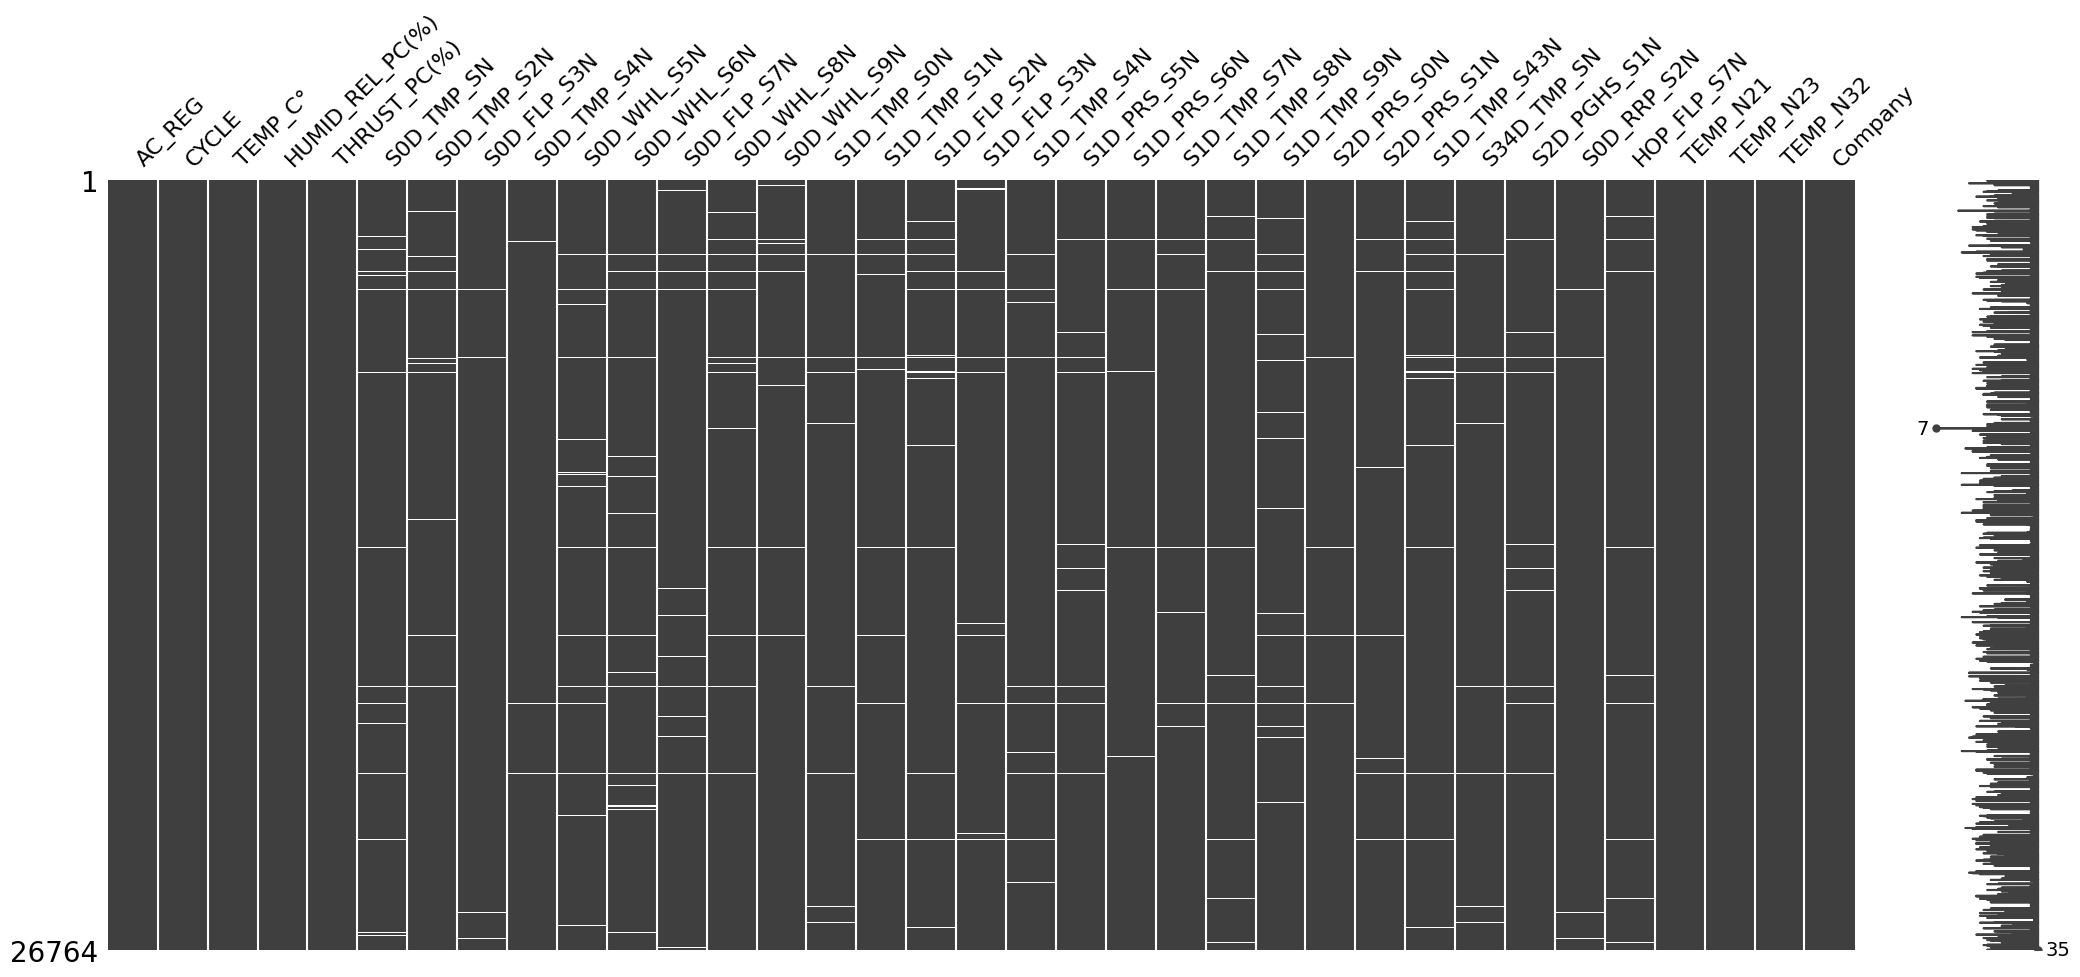

In [12]:
# Réponse
import missingno
missingno.matrix(df_data)

1.7 Retirer les NaN values. Combien de données avez-vous retiré ? Commentez. (5'/35')

In [13]:
# Réponse
df_cleared = pd.DataFrame(df_data.dropna())

In [14]:
print('pourcentage enlevé:', (len(df_data) - len(df_cleared))/len(df_data))

pourcentage enlevé: 0.1227395008219997


# 2 Détection d'outliers
2.1 Utilisez Isolation Forest pour détecter les outliers dans les données numériques. Illustrez vos résultats. (20'/55')

In [15]:
# Réponse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

list_numeric = []
for k in df_data.keys():
    if df_data[k].dtype != 'object':
        list_numeric.append(k)

myRIF = IsolationForest(n_estimators=500, contamination=0.1)
df_cleared.loc[:, '_isoutlier'] = myRIF.fit_predict(np.array(df_cleared.loc[:, list_numeric]))

print(f"anomaly percent : {100*(df_cleared.loc[:, '_isoutlier']==-1).mean()} %")

anomaly percent : 10.000425912517569 %


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


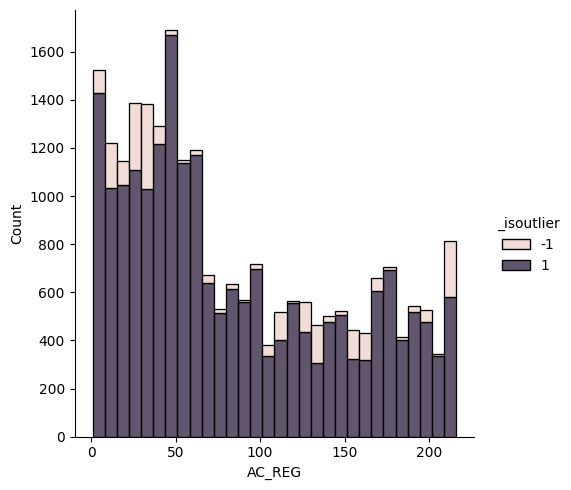

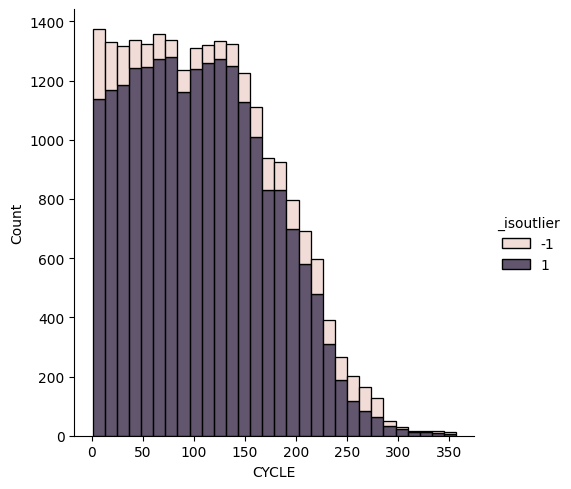

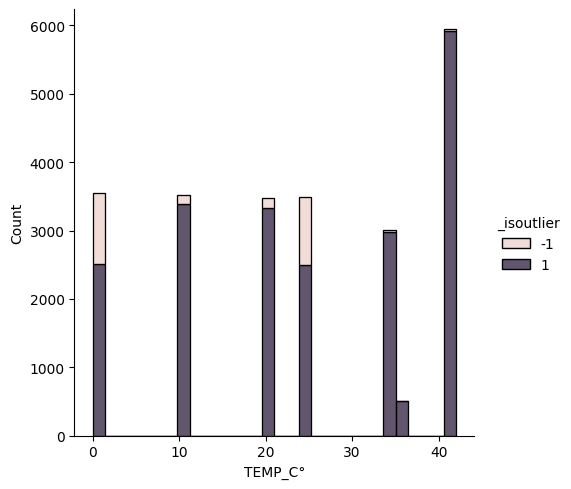

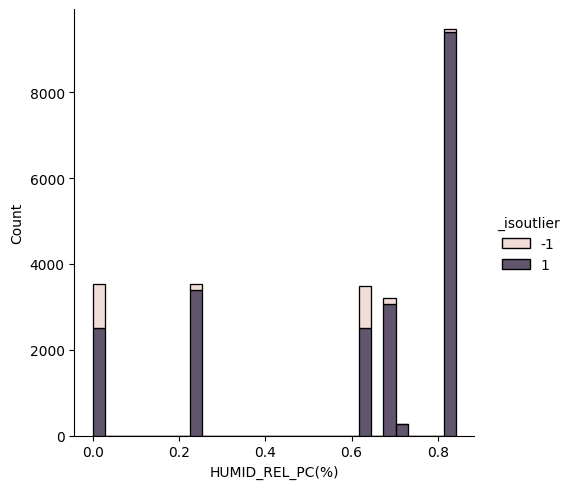

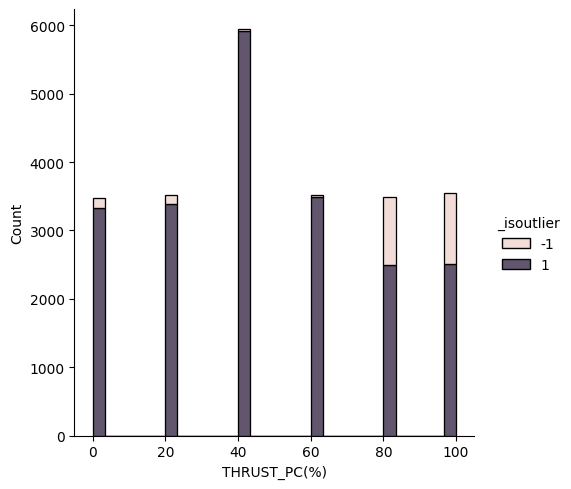

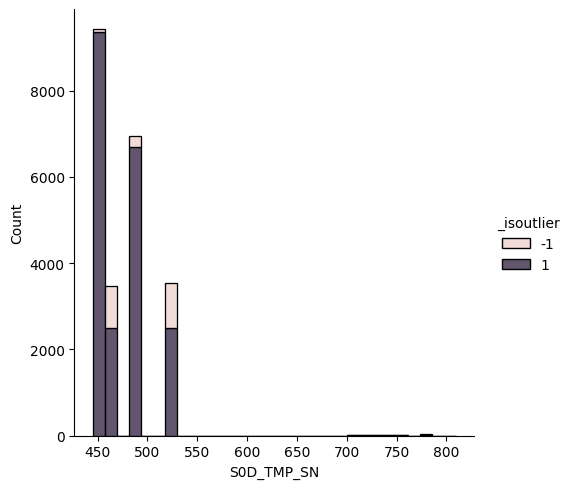

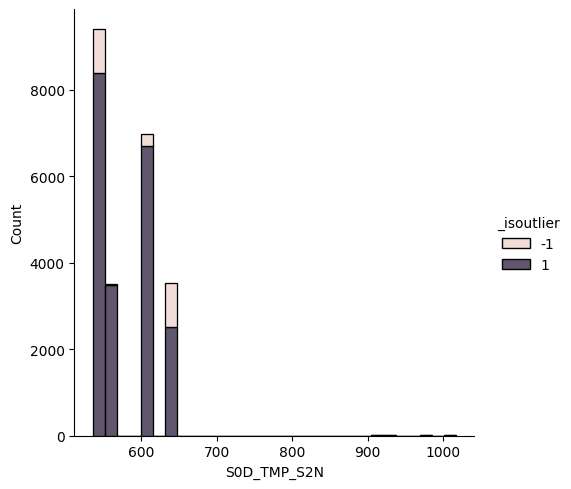

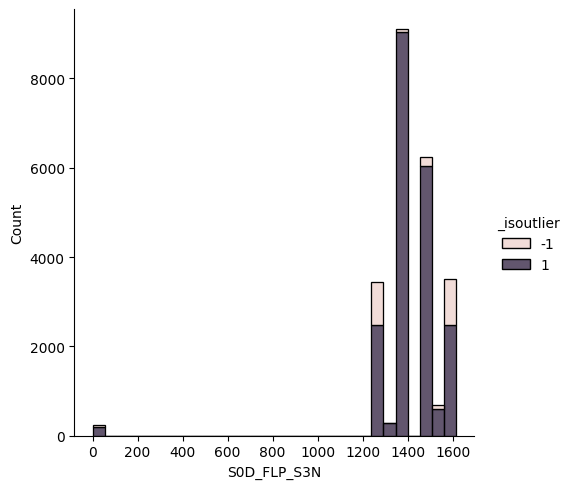

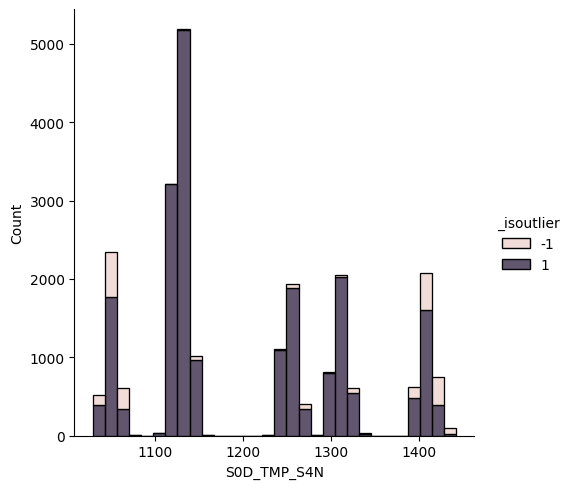

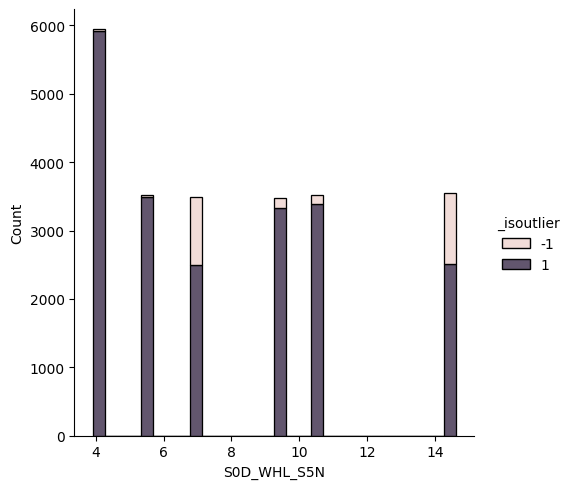

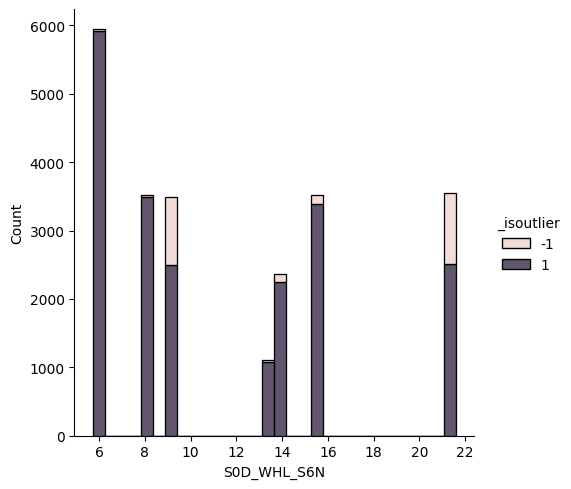

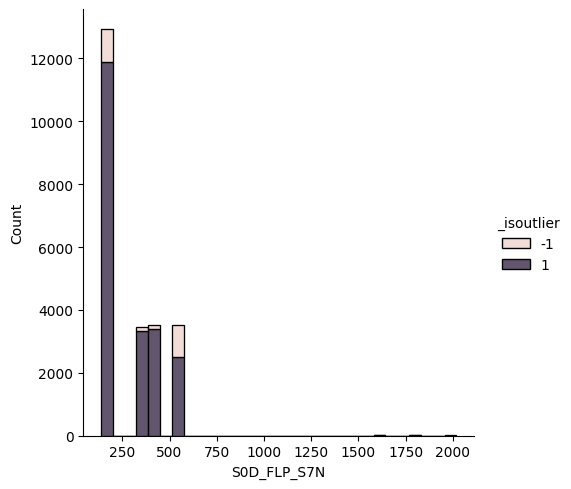

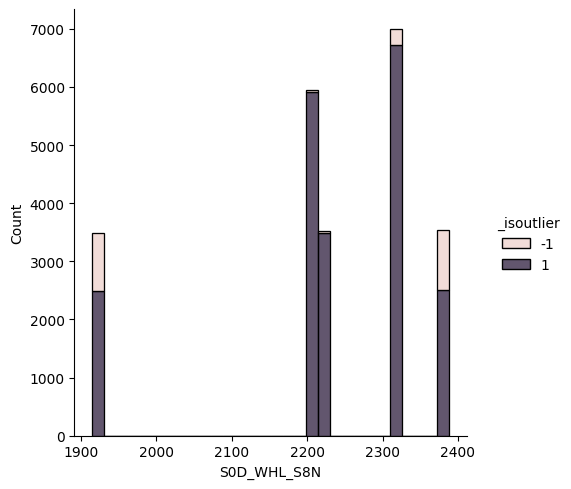

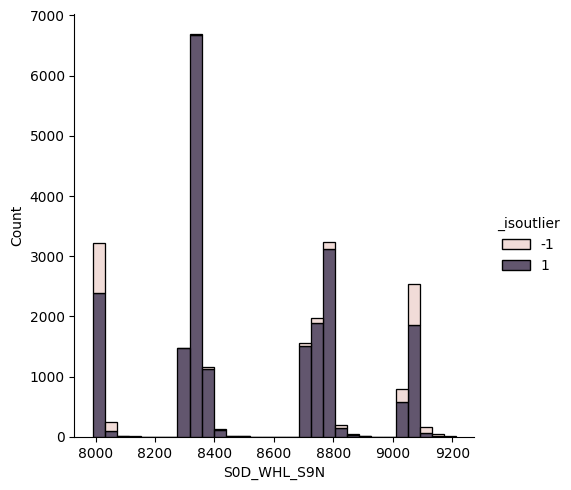

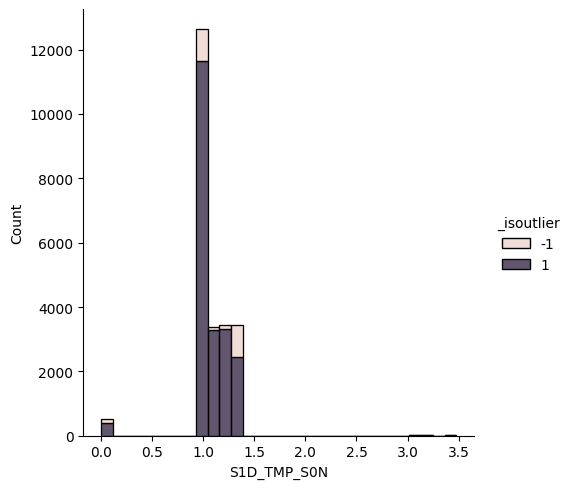

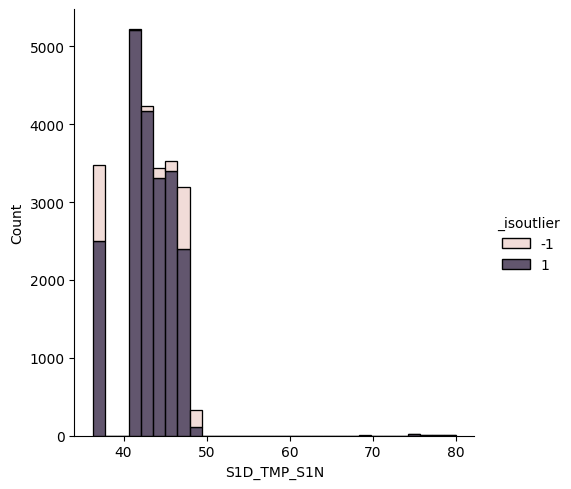

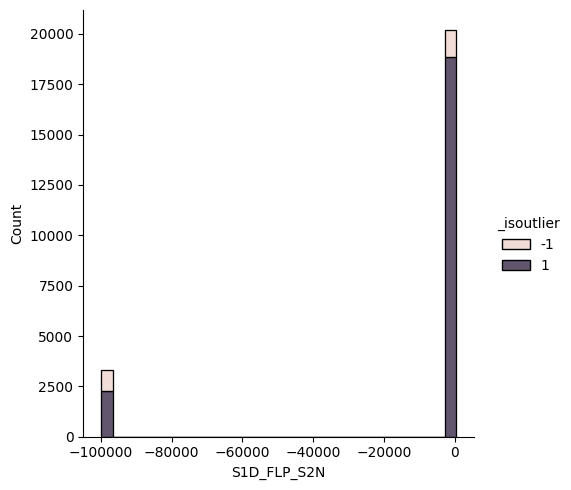

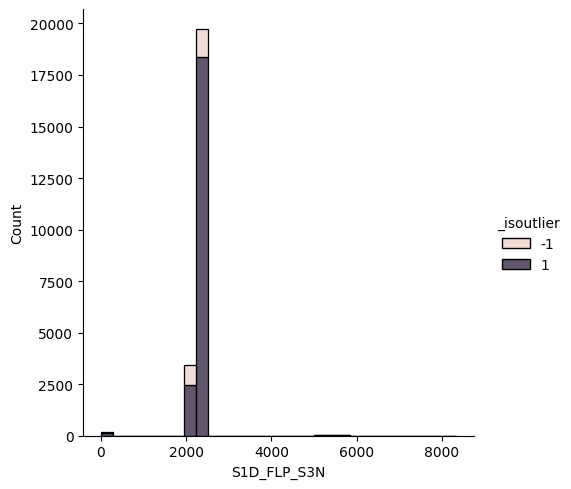

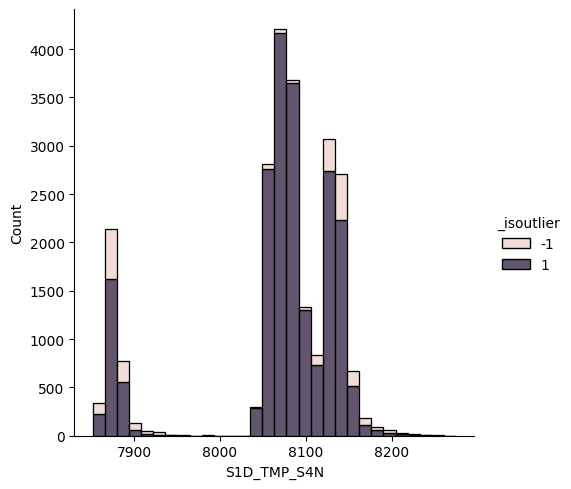

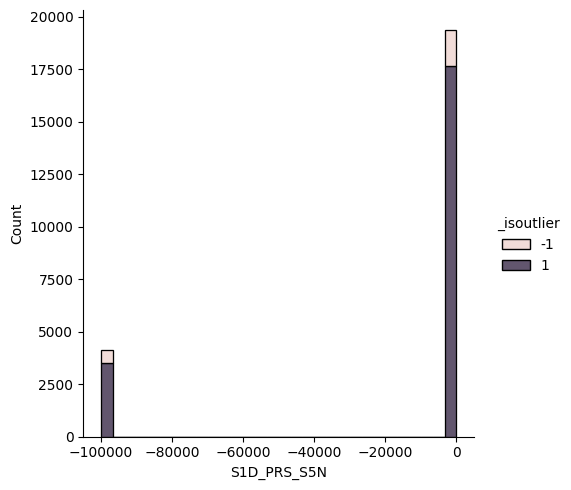

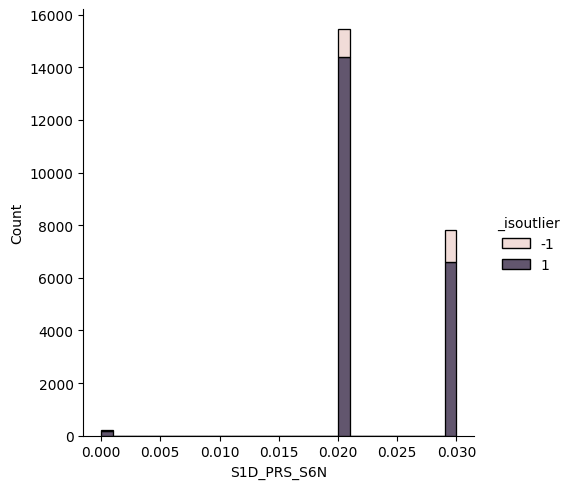

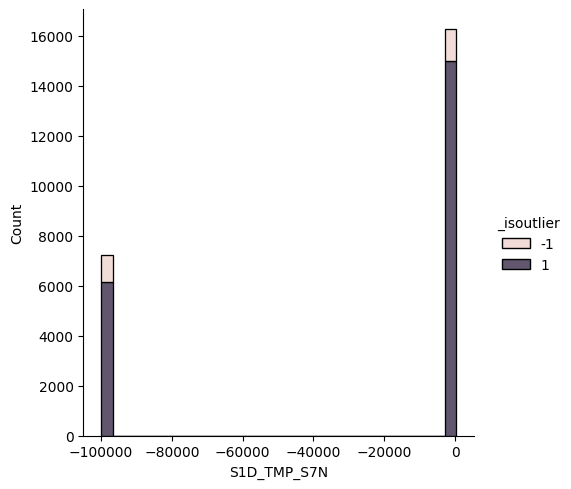

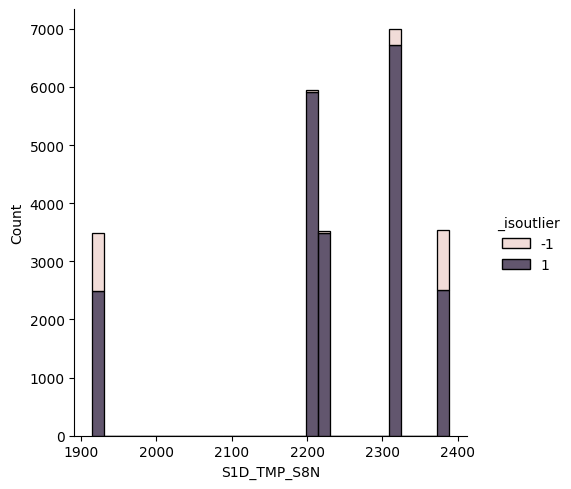

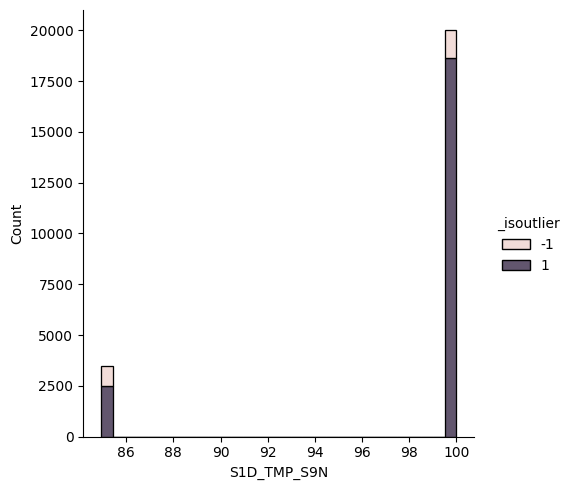

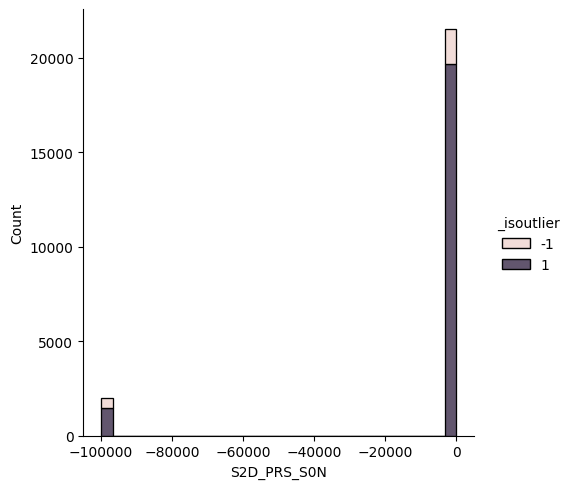

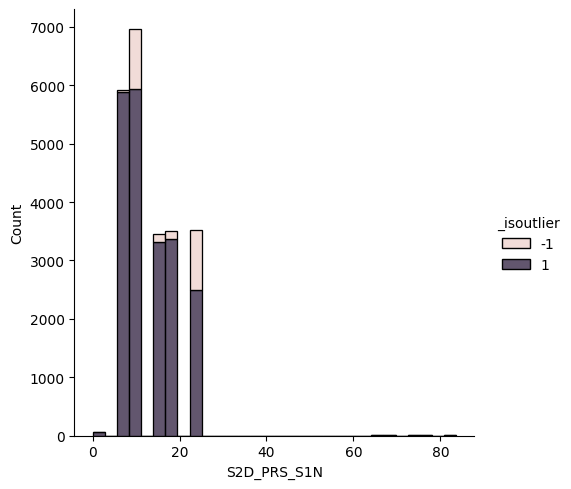

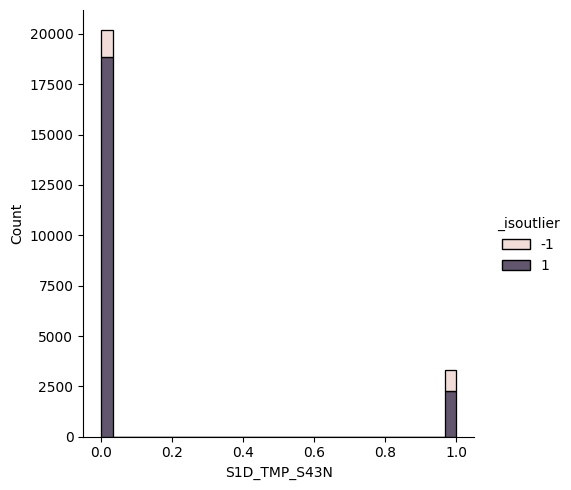

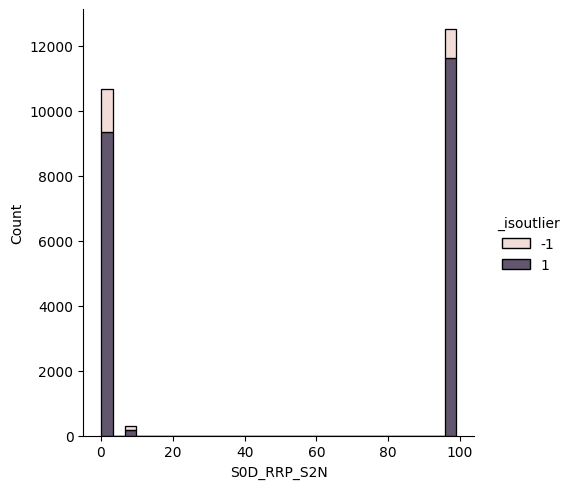

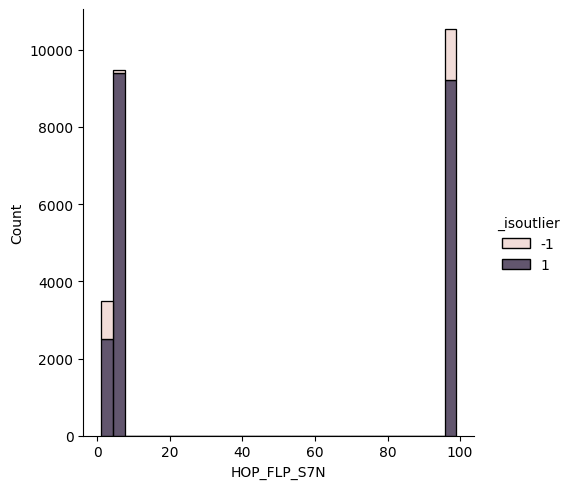

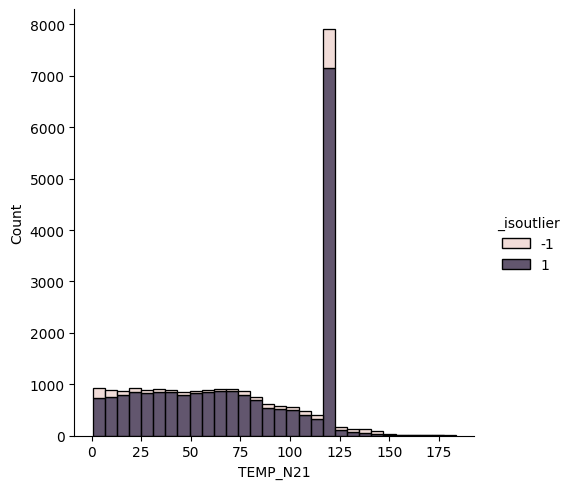

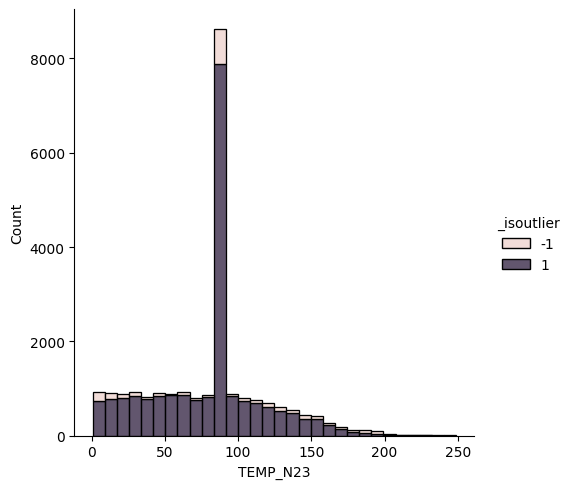

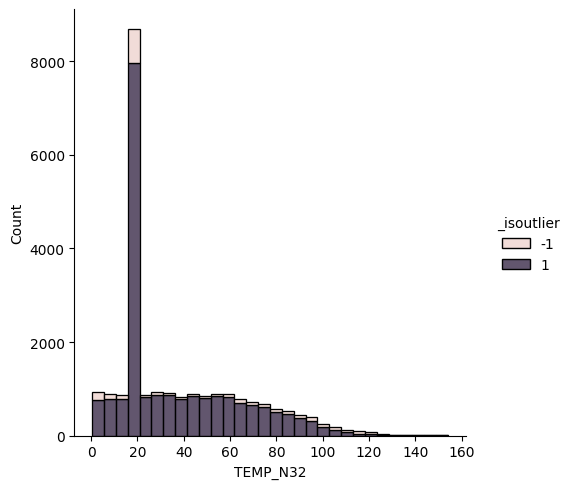

In [16]:
for k in list_numeric:
    sns.displot(data=df_cleared, x=k, hue='_isoutlier', kind='hist', bins=30, multiple="stack")

In [17]:
df_cleared.keys()

Index(['AC_REG', 'CYCLE', 'TEMP_C°', 'HUMID_REL_PC(%)', 'THRUST_PC(%)',
       'S0D_TMP_SN', 'S0D_TMP_S2N', 'S0D_FLP_S3N', 'S0D_TMP_S4N',
       'S0D_WHL_S5N', 'S0D_WHL_S6N', 'S0D_FLP_S7N', 'S0D_WHL_S8N',
       'S0D_WHL_S9N', 'S1D_TMP_S0N', 'S1D_TMP_S1N', 'S1D_FLP_S2N',
       'S1D_FLP_S3N', 'S1D_TMP_S4N', 'S1D_PRS_S5N', 'S1D_PRS_S6N',
       'S1D_TMP_S7N', 'S1D_TMP_S8N', 'S1D_TMP_S9N', 'S2D_PRS_S0N',
       'S2D_PRS_S1N', 'S1D_TMP_S43N', 'S34D_TMP_SN', 'S2D_PGHS_S1N',
       'S0D_RRP_S2N', 'HOP_FLP_S7N', 'TEMP_N21', 'TEMP_N23', 'TEMP_N32',
       'Company', '_isoutlier'],
      dtype='object')

2.2 Utilisez une détection par quantiles pour trouver des outliers (utilisez la méthode basée sur l'écart interquantile IQR). Commentez. (25'/1h15')

In [18]:
# Réponse
Q1 = df_cleared.loc[:, list_numeric].quantile(0.25)
Q3 = df_cleared.loc[:, list_numeric].quantile(0.75)
IQR = Q3 - Q1
df_cleared['_isoutlier_q'] = ((df_cleared.loc[:, list_numeric] < (Q1 - 1.5 * IQR)) | (df_cleared.loc[:, list_numeric] > (Q3 + 1.5 * IQR))).any(axis=1)
print(np.mean(df_cleared['_isoutlier_q']))

0.5400144810255973


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


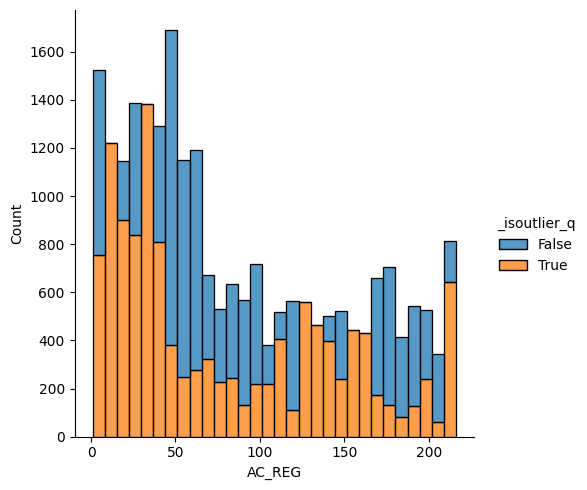

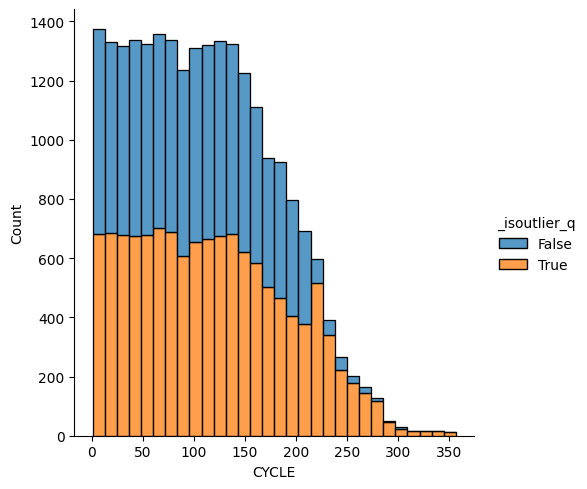

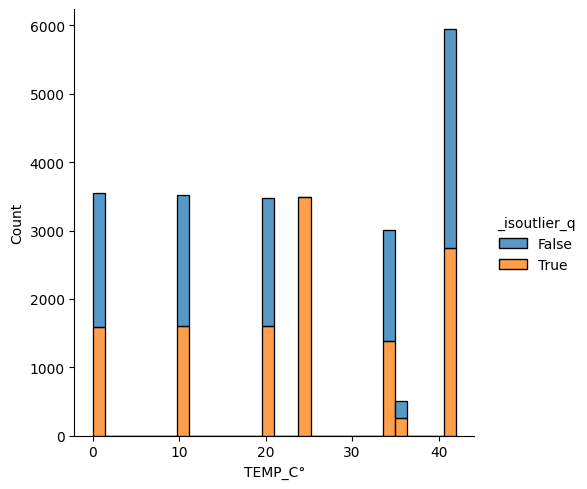

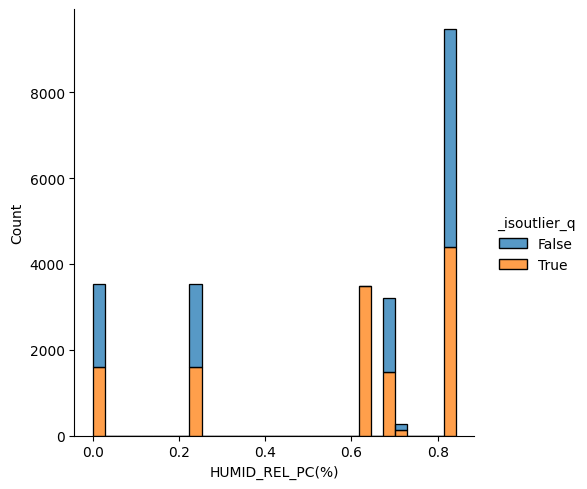

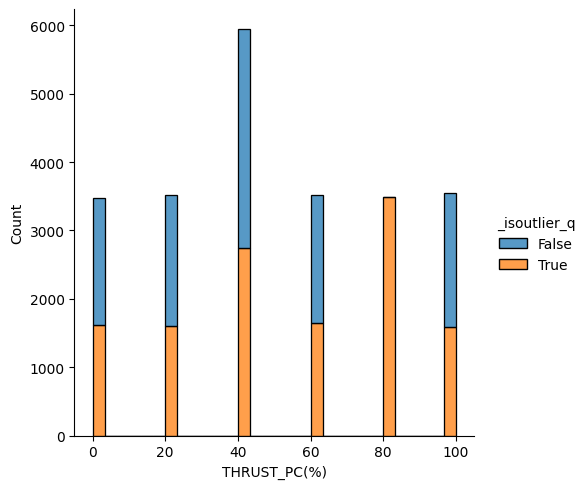

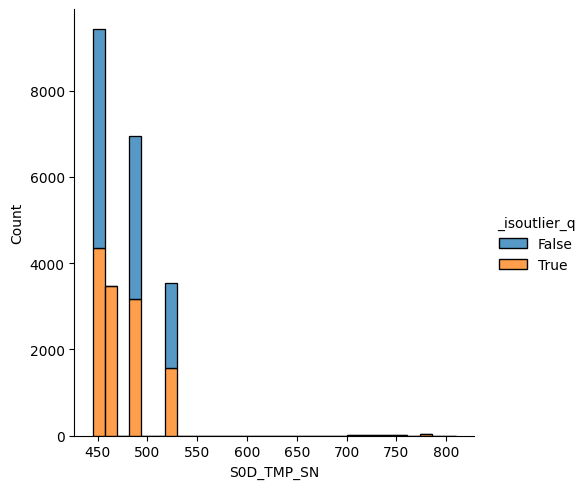

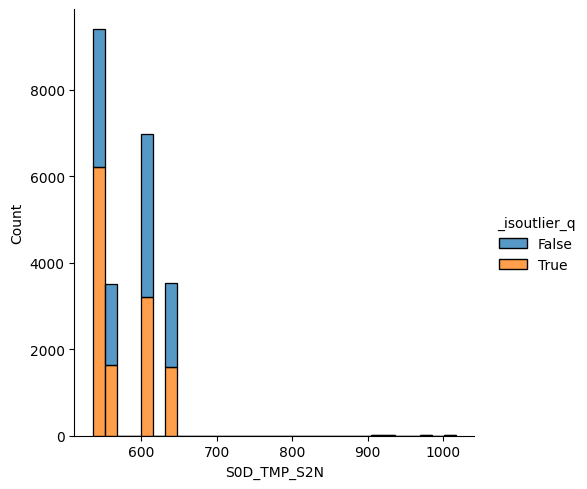

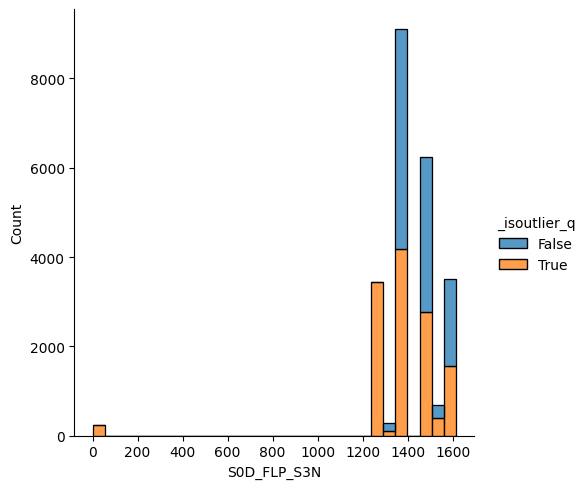

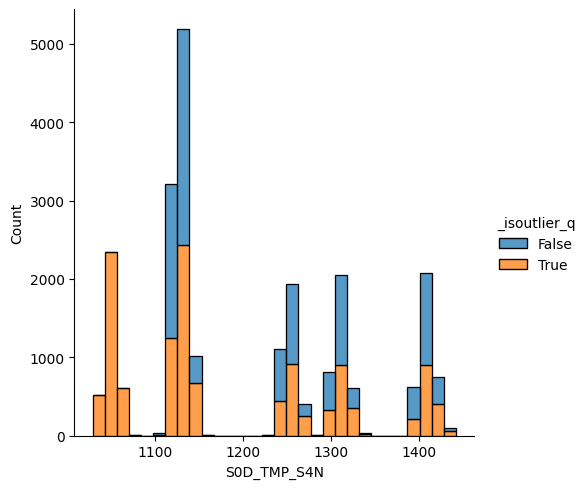

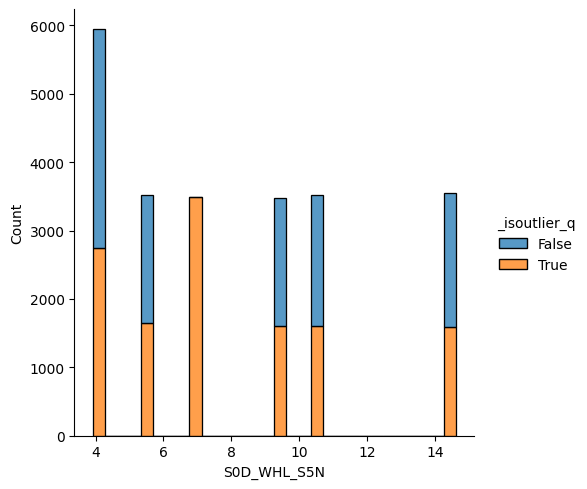

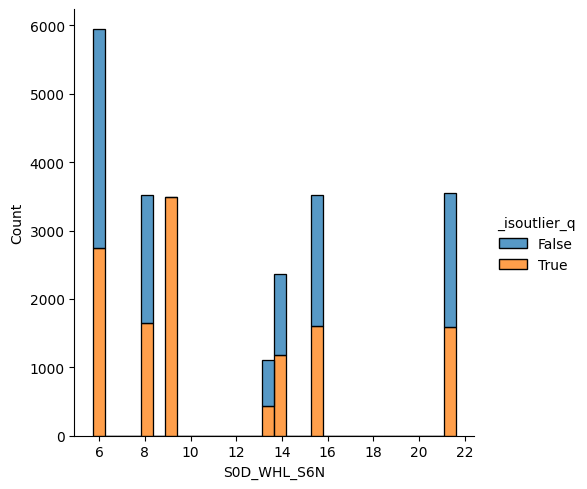

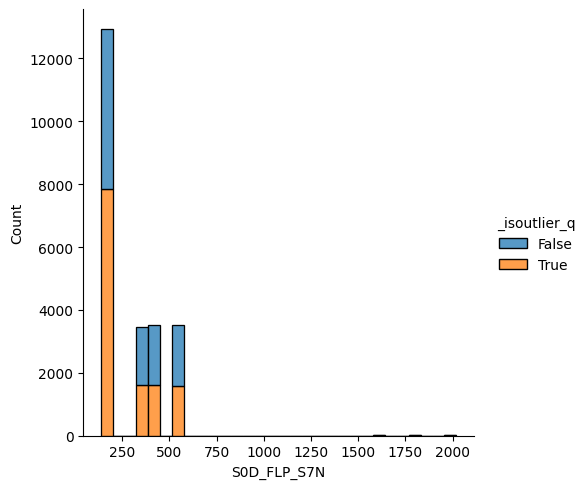

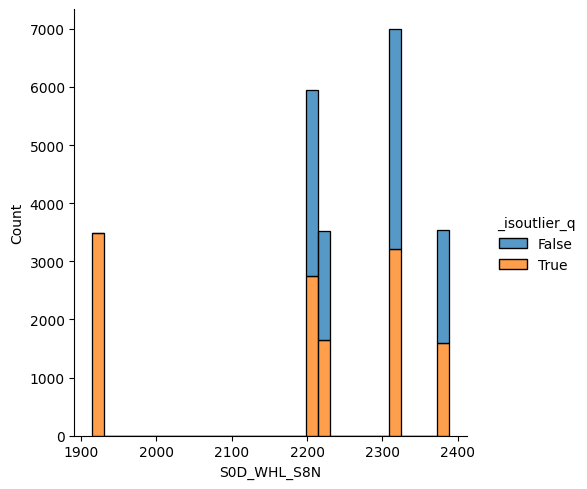

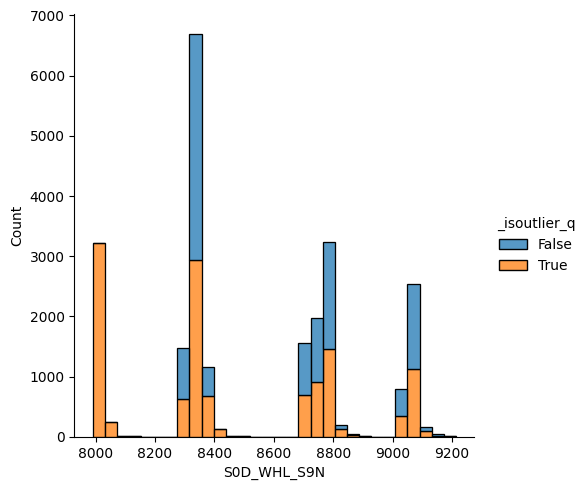

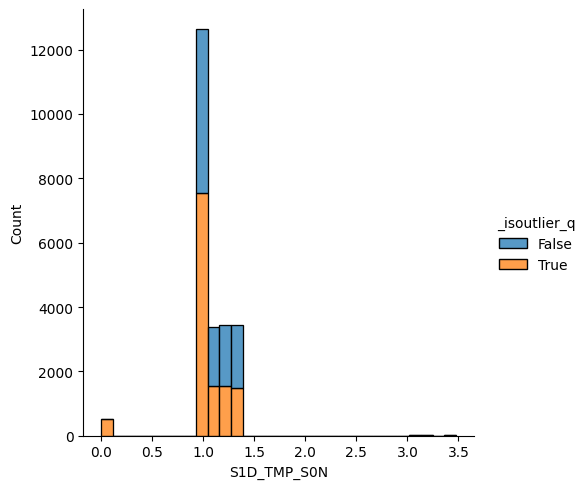

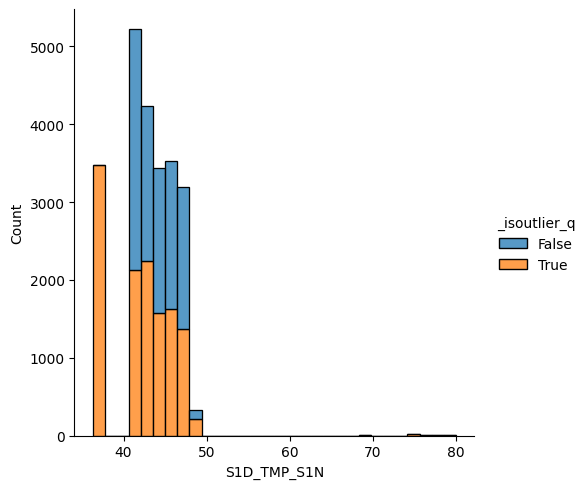

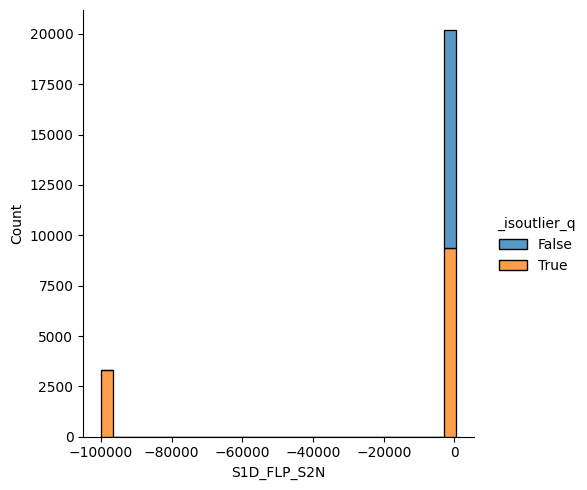

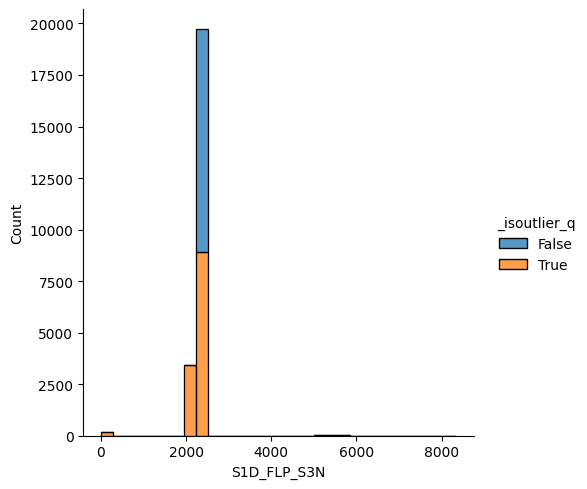

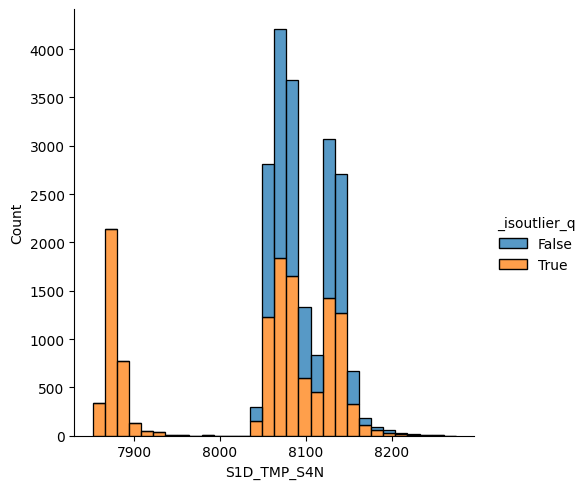

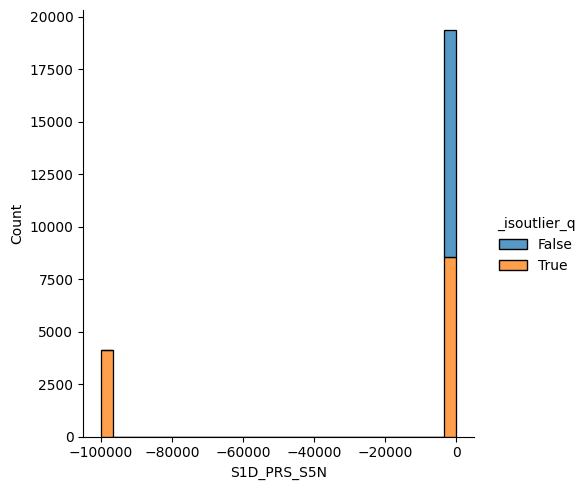

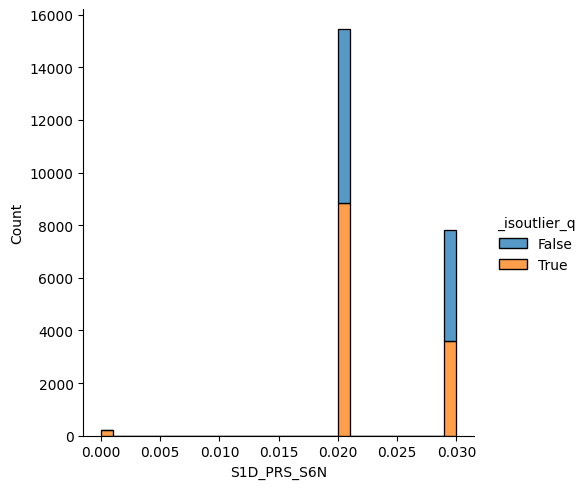

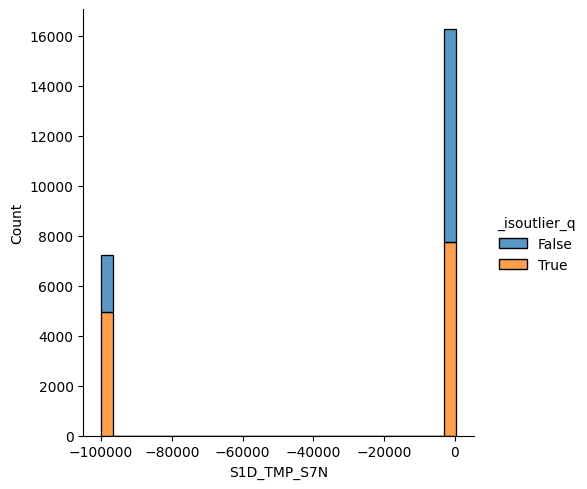

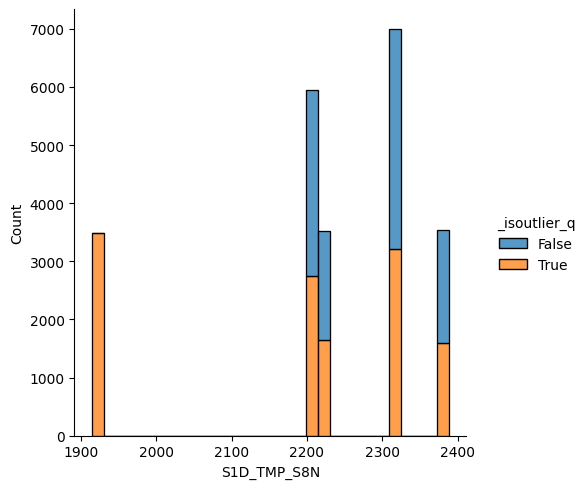

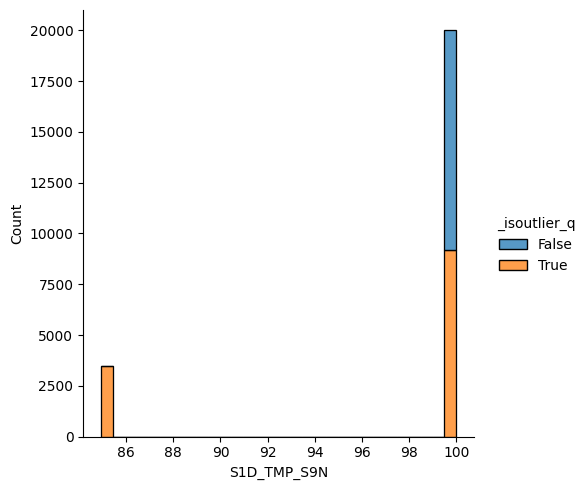

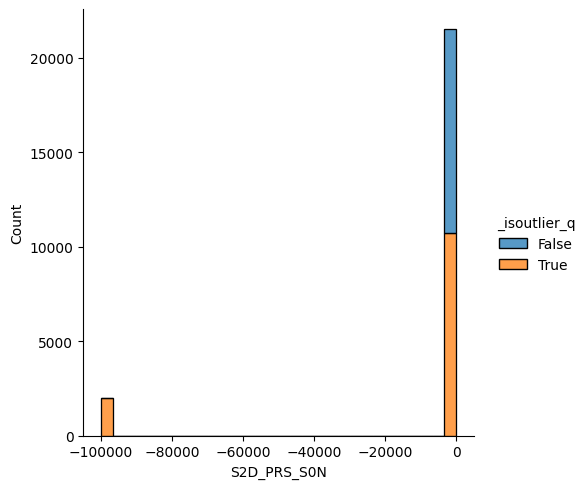

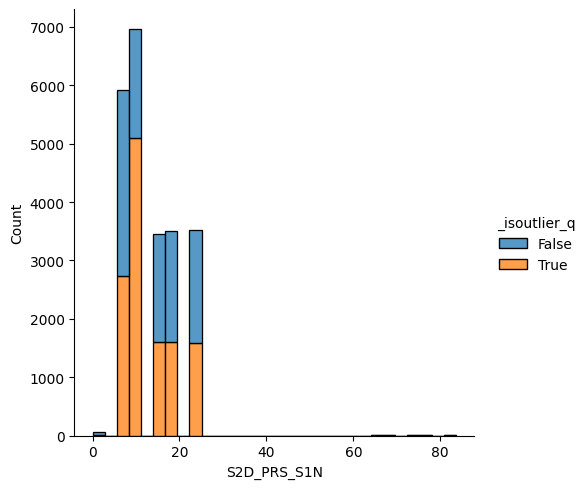

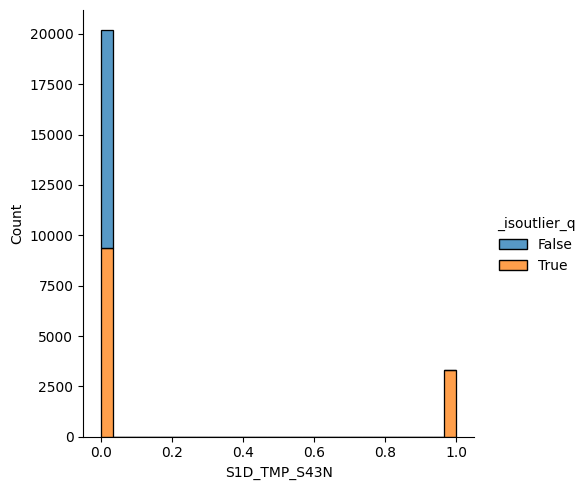

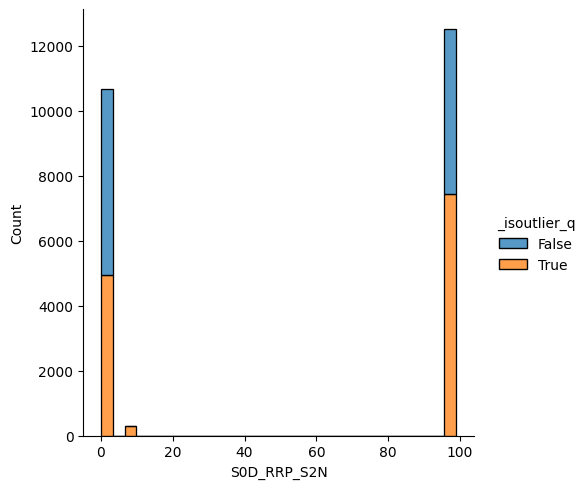

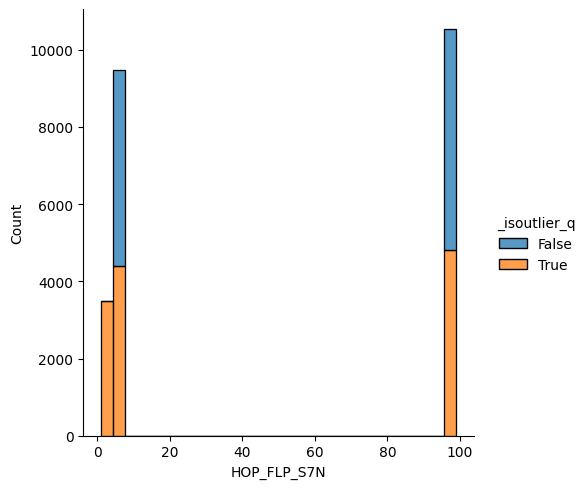

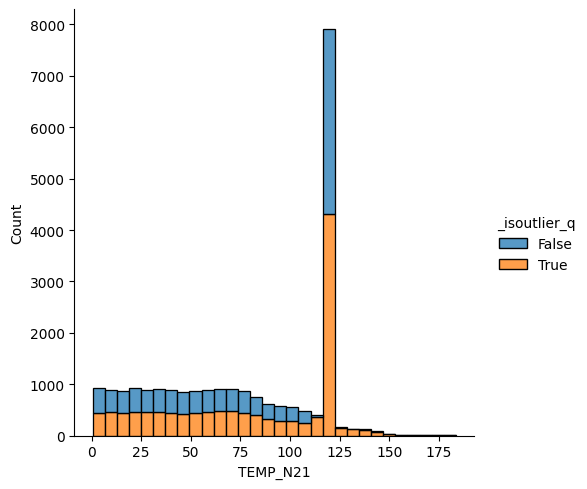

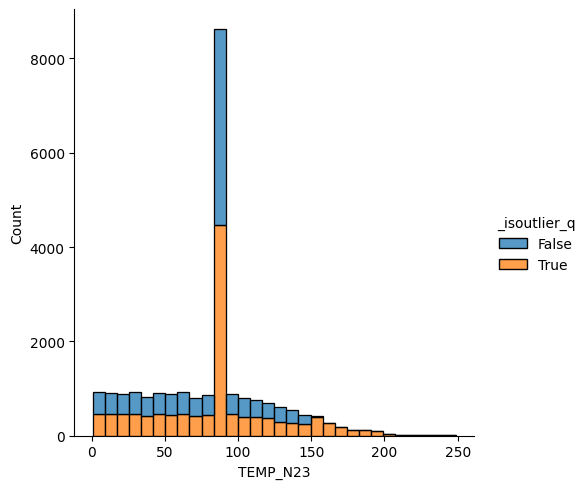

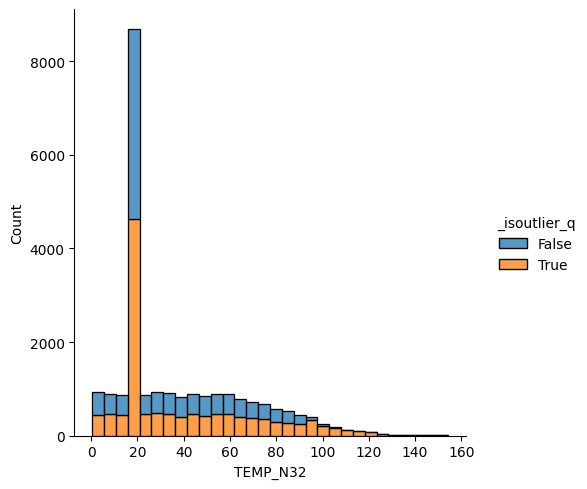

In [19]:
for k in list_numeric:
    sns.displot(data=df_cleared, x=k, hue='_isoutlier_q', kind='hist', bins=30, multiple="stack")

# 3 RUL prediction
3.1 Utilisez pd.to_dummies pour 1-hot encoder les valeur categorielles. (5'/1h20')

In [20]:
cats = [col for col in df_cleared if col not in list_numeric + ['_isoutlier', '_isoutlier_q']]
cats

['S34D_TMP_SN', 'S2D_PGHS_S1N', 'Company']

In [21]:
pd.get_dummies(df_cleared[cats], prefix=cats).head()

,S34D_TMP_SN_AAD,S34D_TMP_SN_FLO,S34D_TMP_SN_GGH,S34D_TMP_SN_PPO,S2D_PGHS_S1N_AAD,S2D_PGHS_S1N_PPO,Company_ANR,Company_FOG,Company_HGH
0,0,0,1,0,0,1,0,0,1
1,0,1,0,0,0,1,0,0,1
2,0,1,0,0,0,1,0,0,1
3,0,1,0,0,0,1,0,0,1
4,0,1,0,0,0,1,0,0,1


In [22]:
df_cleared_one_hot = pd.concat((df_cleared, pd.get_dummies(df_cleared[cats], prefix=cats)), axis=1)
df_cleared_one_hot.head().T

,0,1,2,3,4
AC_REG,2.0,2.0,2.0,2.0,2.0
CYCLE,1.0,2.0,3.0,4.0,5.0
TEMP_C°,0.0017,35.0026,42.0011,42.0003,20.0023
HUMID_REL_PC(%),0.0006,0.8405,0.84,0.8407,0.7
THRUST_PC(%),100.0,60.0,40.0,40.0,0.0
S0D_TMP_SN,518.67,449.44,445.0,445.0,491.19
S0D_TMP_S2N,641.59,554.68,548.63,548.88,606.99
S0D_FLP_S3N,1578.61,1357.66,1347.31,1350.73,1477.32
S0D_TMP_S4N,1401.71,1117.74,1118.9,1125.61,1237.14
S0D_WHL_S5N,14.62,5.48,3.91,3.91,9.35


In [23]:
# Vérification des types
for key, dtype in zip(df_cleared_one_hot.keys(), df_cleared_one_hot.dtypes):
    print(key, dtype)

AC_REG float64
CYCLE float64
TEMP_C° float64
HUMID_REL_PC(%) float64
THRUST_PC(%) float64
S0D_TMP_SN float64
S0D_TMP_S2N float64
S0D_FLP_S3N float64
S0D_TMP_S4N float64
S0D_WHL_S5N float64
S0D_WHL_S6N float64
S0D_FLP_S7N float64
S0D_WHL_S8N float64
S0D_WHL_S9N float64
S1D_TMP_S0N float64
S1D_TMP_S1N float64
S1D_FLP_S2N float64
S1D_FLP_S3N float64
S1D_TMP_S4N float64
S1D_PRS_S5N float64
S1D_PRS_S6N float64
S1D_TMP_S7N float64
S1D_TMP_S8N float64
S1D_TMP_S9N float64
S2D_PRS_S0N float64
S2D_PRS_S1N float64
S1D_TMP_S43N float64
S34D_TMP_SN object
S2D_PGHS_S1N object
S0D_RRP_S2N float64
HOP_FLP_S7N float64
TEMP_N21 float64
TEMP_N23 float64
TEMP_N32 float64
Company object
_isoutlier int64
_isoutlier_q bool
S34D_TMP_SN_AAD uint8
S34D_TMP_SN_FLO uint8
S34D_TMP_SN_GGH uint8
S34D_TMP_SN_PPO uint8
S2D_PGHS_S1N_AAD uint8
S2D_PGHS_S1N_PPO uint8
Company_ANR uint8
Company_FOG uint8
Company_HGH uint8


3.2 Créez la liste des features qui serviront à l'entrainement du model. Vous prendrez toutes les colonnes numériques de la dataFrame excepté "CYCLE". Calculez une colonne qui contient la RUL. Etudiez la distribution de la RUL. Commentez. (25'/1h45')

In [24]:
features = [col for col in df_cleared_one_hot.select_dtypes('number').columns if col not in ['CYCLE', 'AC_REG']]
df_cleared_one_hot['RUL'] = df_cleared_one_hot['CYCLE'].copy()
for unit in df_cleared_one_hot['AC_REG'].unique():
    tmp_df = df_cleared_one_hot.loc[df_cleared_one_hot['AC_REG']==unit, 'CYCLE'].copy()
    last_value = tmp_df.iloc[-1]
    indexes = df_cleared_one_hot.loc[:, 'AC_REG']==unit
    all_value = np.array(tmp_df)
    df_cleared_one_hot.loc[indexes, 'RUL'] = all_value - last_value


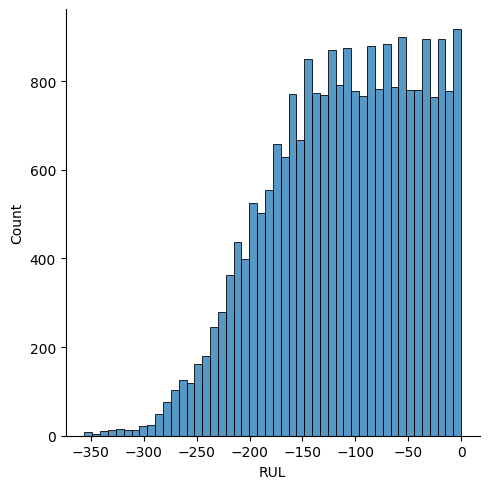

In [25]:
import seaborn as sns

sns.displot(df_cleared_one_hot['RUL'])

3.3 Séparez votre dataset entre un jeu d'entrainement et de test. A votre avis, faut il faire particulierement attention à cette repartition ? Risquons nous de faire survenir des biais ? Apprenez un modèle linéaire sur toutes les données. (10'/1h55')

In [26]:
# Ne pas mélanger les données d'un même avion
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=2)

X = df_cleared_one_hot.loc[:, features]
y = df_cleared_one_hot.loc[:, 'RUL']

for train_index, test_index in gkf.split(X, groups=df_cleared_one_hot['AC_REG']):
     print("TRAIN:", len(train_index), "TEST:", (test_index))

X_train, X_test = X.iloc[train_index,:], X.iloc[test_index, :]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

TRAIN: 11710 TEST: [  152   153   154 ... 23476 23477 23478]
TRAIN: 11769 TEST: [    0     1     2 ... 22664 22665 22666]
(11769, 40) (11710, 40)
(11769,) (11710,)


train score: 0.6270795652014329
test score: 0.5254190776801017


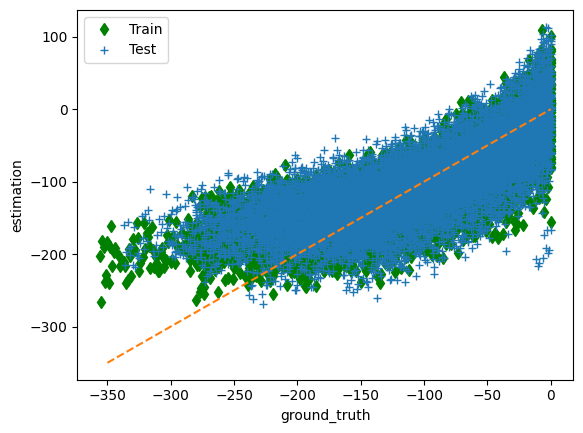

In [27]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
print('train score:', model.score(X_train,y_train))
print('test score:', model.score(X_test,y_test))

plt.plot(y_train, model.predict(X_train), 'gd')
plt.plot(y_test, model.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.4 Etudiez la correlation entre les features numeriques et la RUL. Commentez. (5'/2h)

<ipython-input-28-59b53f2f544d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cleared_one_hot.corr().RUL.sort_values().plot.barh()


Text(0.5, 0, 'TEMP_N21')

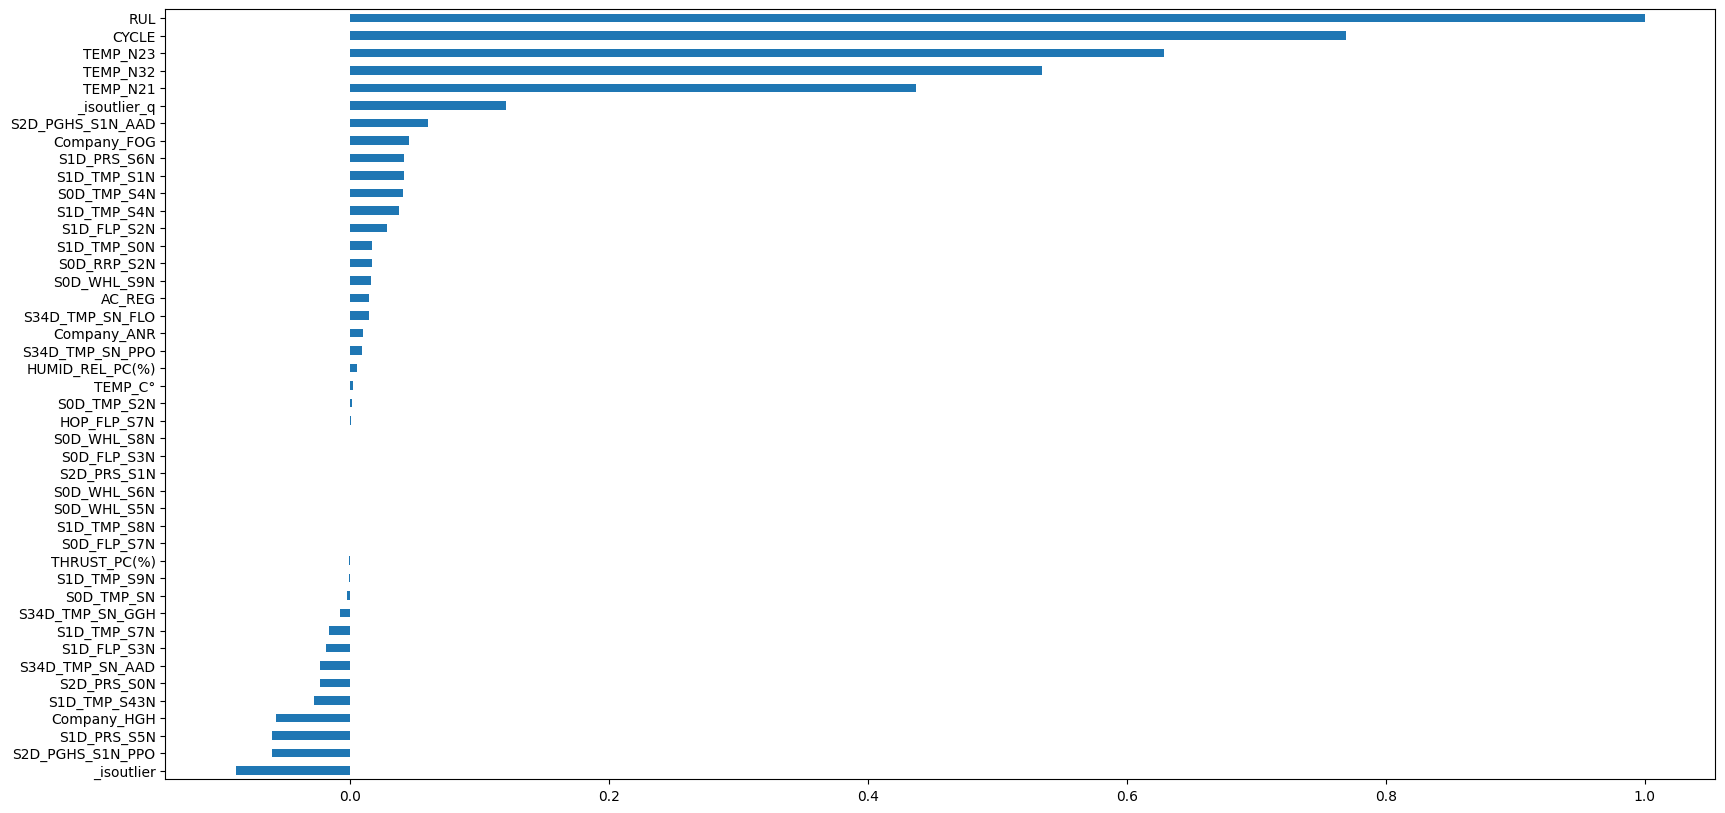

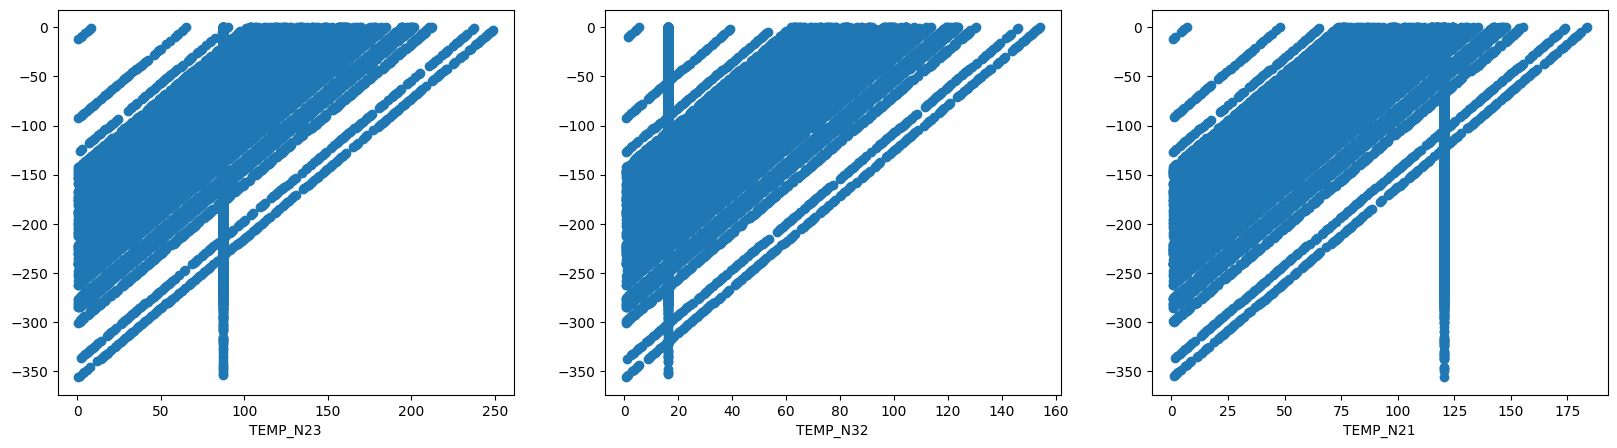

In [28]:
plt.figure(figsize=(20, 10))
df_cleared_one_hot.corr().RUL.sort_values().plot.barh()
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N23']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N23')
plt.subplot(1, 3, 2)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N32']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N32')
plt.subplot(1, 3, 3)
plt.scatter(df_cleared_one_hot.loc[:, ['TEMP_N21']], df_cleared_one_hot.loc[:, ['RUL']])
plt.xlabel('TEMP_N21')

train score 0.4488787157537866
test score 0.46511905052065505


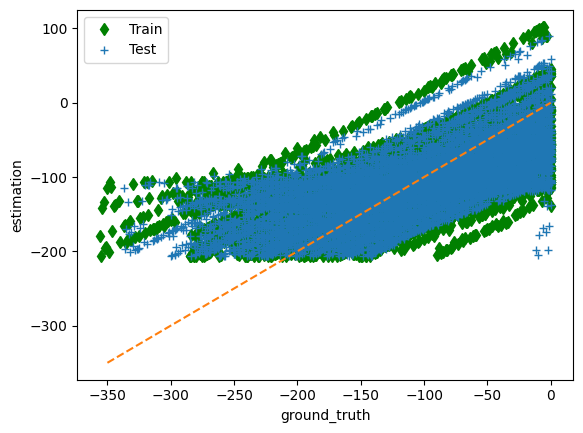

In [29]:
from sklearn.linear_model import LinearRegression
features_selected = ['TEMP_N23', 'TEMP_N32', 'TEMP_N21']

model_selected = LinearRegression()
model_selected.fit(X_train.loc[:, features_selected],
          y_train)

print('train score', model_selected.score(X_train.loc[:, features_selected],y_train))
print('test score', model_selected.score(X_test.loc[:, features_selected],y_test))

plt.plot(y_train, model_selected.predict(X_train.loc[:, features_selected]), 'gd')
plt.plot(y_test, model_selected.predict(X_test.loc[:, features_selected]), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.5 Faites de la sélection de features grâce à RFE. (Recursive Feature Elimination). Ne considerez que les valeurs numériques. (5'/2h05')

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [31]:
model = LinearRegression()
rfe = RFE(model,n_features_to_select=5)
model_linear_rfe = rfe.fit(X_train, y_train)

In [32]:
print("Num Features: %s" % (model_linear_rfe.n_features_))
print("Selected Features: %s" % (model_linear_rfe.support_))
print("Feature Ranking: %s" % (model_linear_rfe.ranking_))

for i, name in enumerate(features):
    if model_linear_rfe.support_[i]:
        print(name)

Num Features: 5
Selected Features: [False  True False False False False False  True  True False False False
 False False False False False False  True False False  True False False
 False False False False False False False False False False False False
 False False False False]
Feature Ranking: [ 5  1  3 32 28 30 17  1  1 35  4 21  8 19 33 31 26 12  1 36  6  1 34 25
 15 29  2 27 23 24 20 18 22 13  7 10 11 16 14  9]
HUMID_REL_PC(%)
S0D_WHL_S5N
S0D_WHL_S6N
S1D_PRS_S6N
S1D_TMP_S9N


train score: 0.04953947717528895
test score: -0.07097217870855577


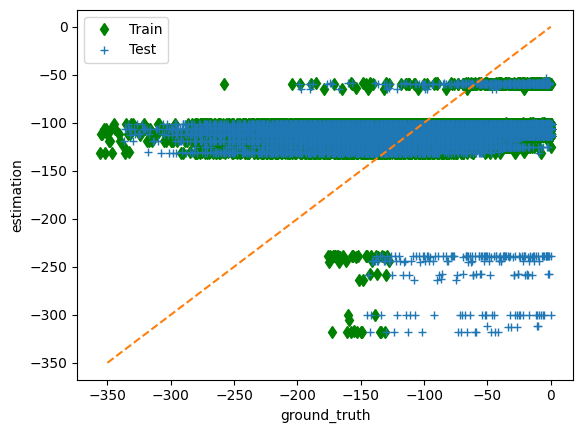

In [33]:
print('train score:', model_linear_rfe.score(X_train, y_train))
print('test score:', model_linear_rfe.score(X_test, y_test))

plt.plot(y_train, model_linear_rfe.predict(X_train), 'gd')
plt.plot(y_test, model_linear_rfe.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

In [34]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

In [35]:
model = RandomForestRegressor()
rfe = RFE(model,n_features_to_select=5)
model_RF_rfe = rfe.fit(X_train, y_train)

In [36]:
print("Num Features: %s" % (model_RF_rfe.n_features_))
print("Selected Features: %s" % (model_RF_rfe.support_))
print("Feature Ranking: %s" % (model_RF_rfe.ranking_))

for i, name in enumerate(features):
    if model_RF_rfe.support_[i]:
        print(name)

Num Features: 5
Selected Features: [False False False False False False  True False False False False False
 False  True False  True False False False False False False False False
 False False False  True  True False False False False False False False
 False False False False]
Feature Ranking: [16 17 24 27 12 10  1 30 22 11  8 14 26  1  5  1  3  4 21  9 29 36  7 13
 18 28 35  1  1  2 25 31 32 34 33 20 23 19 15  6]
S0D_TMP_S4N
S1D_TMP_S1N
S1D_FLP_S3N
TEMP_N21
TEMP_N23


train score: 0.9516969465656533
test score: 0.6529783658767827


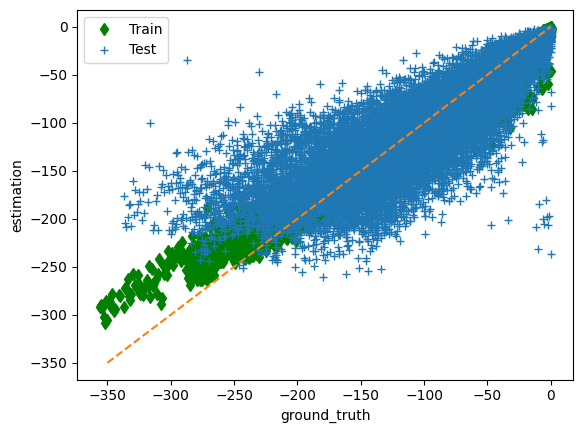

In [37]:
print('train score:', model_RF_rfe.score(X_train, y_train))
print('test score:', model_RF_rfe.score(X_test, y_test))

plt.plot(y_train, model_RF_rfe.predict(X_train), 'gd')
plt.plot(y_test, model_RF_rfe.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

3.6 Apprenez un LASSO et comparez. (10'/2h15')

In [38]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(max_iter=25000, alpha=5.0)
lasso_model.fit(X_train, y_train)

Lasso(alpha=5.0, max_iter=25000)

In [39]:
for i, name in enumerate(features):
    if np.abs(lasso_model.coef_[i]) > 0.0:
        print(name, lasso_model.coef_[i])

THRUST_PC(%) -2.027004705129516
S0D_TMP_SN -0.006567986974551214
S0D_TMP_S2N -0.01718608902846755
S0D_FLP_S3N -0.02462695623431022
S0D_TMP_S4N 0.9053768743737499
S0D_FLP_S7N -0.0047658171269213895
S0D_WHL_S9N 0.43078118300027546
S1D_FLP_S2N 3.811394219423766e-05
S1D_FLP_S3N -0.00979418857179905
S1D_TMP_S4N -0.42884100909849227
S1D_PRS_S5N -6.263071733897476e-05
S1D_TMP_S7N -9.54018052189109e-07
S1D_TMP_S8N -0.5591938198957158
S2D_PRS_S0N -0.000379854021539023
S0D_RRP_S2N 0.12870650454061883
HOP_FLP_S7N -3.362825197943239
TEMP_N21 0.2029649198520388
TEMP_N23 0.6822532422588461
TEMP_N32 0.5070994098837329
Company_HGH -2.795085108974906


train score: 0.5147902390254753
test score: 0.48159393348598534


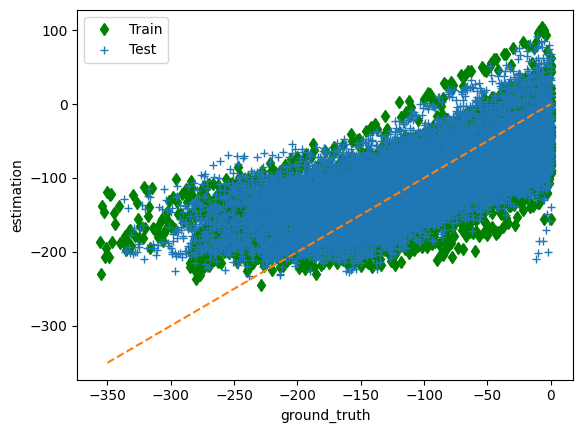

In [40]:
print('train score:', lasso_model.score(X_train, y_train))
print('test score:', lasso_model.score(X_test, y_test))

plt.plot(y_train, lasso_model.predict(X_train), 'gd')
plt.plot(y_test, lasso_model.predict(X_test), '+')
plt.xlabel('ground_truth')
plt.ylabel('estimation')
plt.legend(['Train', 'Test'])
plt.plot([-350, 0], [-350, 0], '--');

# 4. Recurrent Deep Survival Machine
Dans cette partie nous allons utiliser l'architecture RDSM.

In [42]:
from google.colab import files
uploaded = files.upload()

Saving auton_survival.zip to auton_survival.zip


In [43]:
!unzip auton_survival

Archive:  auton_survival.zip
   creating: auton_survival/auton_survival/
  inflating: auton_survival/auton_survival/__init__.py  
   creating: auton_survival/auton_survival/__pycache__/
  inflating: auton_survival/auton_survival/__pycache__/__init__.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/datasets.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/estimators.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/experiments.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/metrics.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/preprocessing.cpython-38.pyc  
  inflating: auton_survival/auton_survival/__pycache__/utils.cpython-38.pyc  
  inflating: auton_survival/auton_survival/datasets.py  
   creating: auton_survival/auton_survival/datasets/
  inflating: auton_survival/auton_survival/datasets/framingham.csv  
  inflating: auton_survival/auton_survival/datasets/pbc2.csv  

In [ ]:
!pip install scikit-survival
# Pensez à redémarrer le kernel


In [1]:
%load_ext autoreload
%autoreload 2
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/content/')
sys.path.append('/content/auton_survival')
sys.path.append('/content/auton_survival/auton_survival/')
# Pensez à redémarrer le kernel (une seconde fois)

In [2]:
from auton_survival import datasets

outcomes, features = datasets.load_support()
x, t, e = datasets.load_dataset('PBC', sequential = True)

$x$ est une liste qui contient des séries temporelles de 25 variables. $t$ est le temps avant événement ou avant censure, et $e$ l'indicateur de censure.

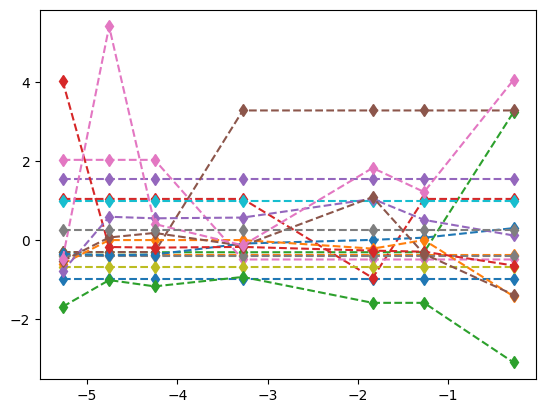

In [3]:
selected_unit = 3
plt.figure()
plt.plot(-t[selected_unit], x[selected_unit],'--d');

Nous montrons ici quelques graphes informatifs sur le dataset.

In [4]:
names = ['Penicillin',
 'Sex',
 'Ascites',
 'Hepatomegaly',
 'Spiders',
 'Edema despite diuretics',
 'Edema no diuretics',
 'histologic 2',
 'histologic 3',
 'histologic 4',
 'serBilir',
 'serChol',
 'albumin',
 'alkaline',
 'SGOT',
 'platelets',
 'prothrombin',
 'age']
FlattenDataSet = pd.DataFrame(np.concatenate(x), columns=names)
index_list = []
for idx, individual in enumerate(x):
    index_list.append(idx * np.ones(len(individual)))

FlattenDataSet['Index'] = np.concatenate(index_list)

FlattenTime = pd.DataFrame(np.concatenate(t))

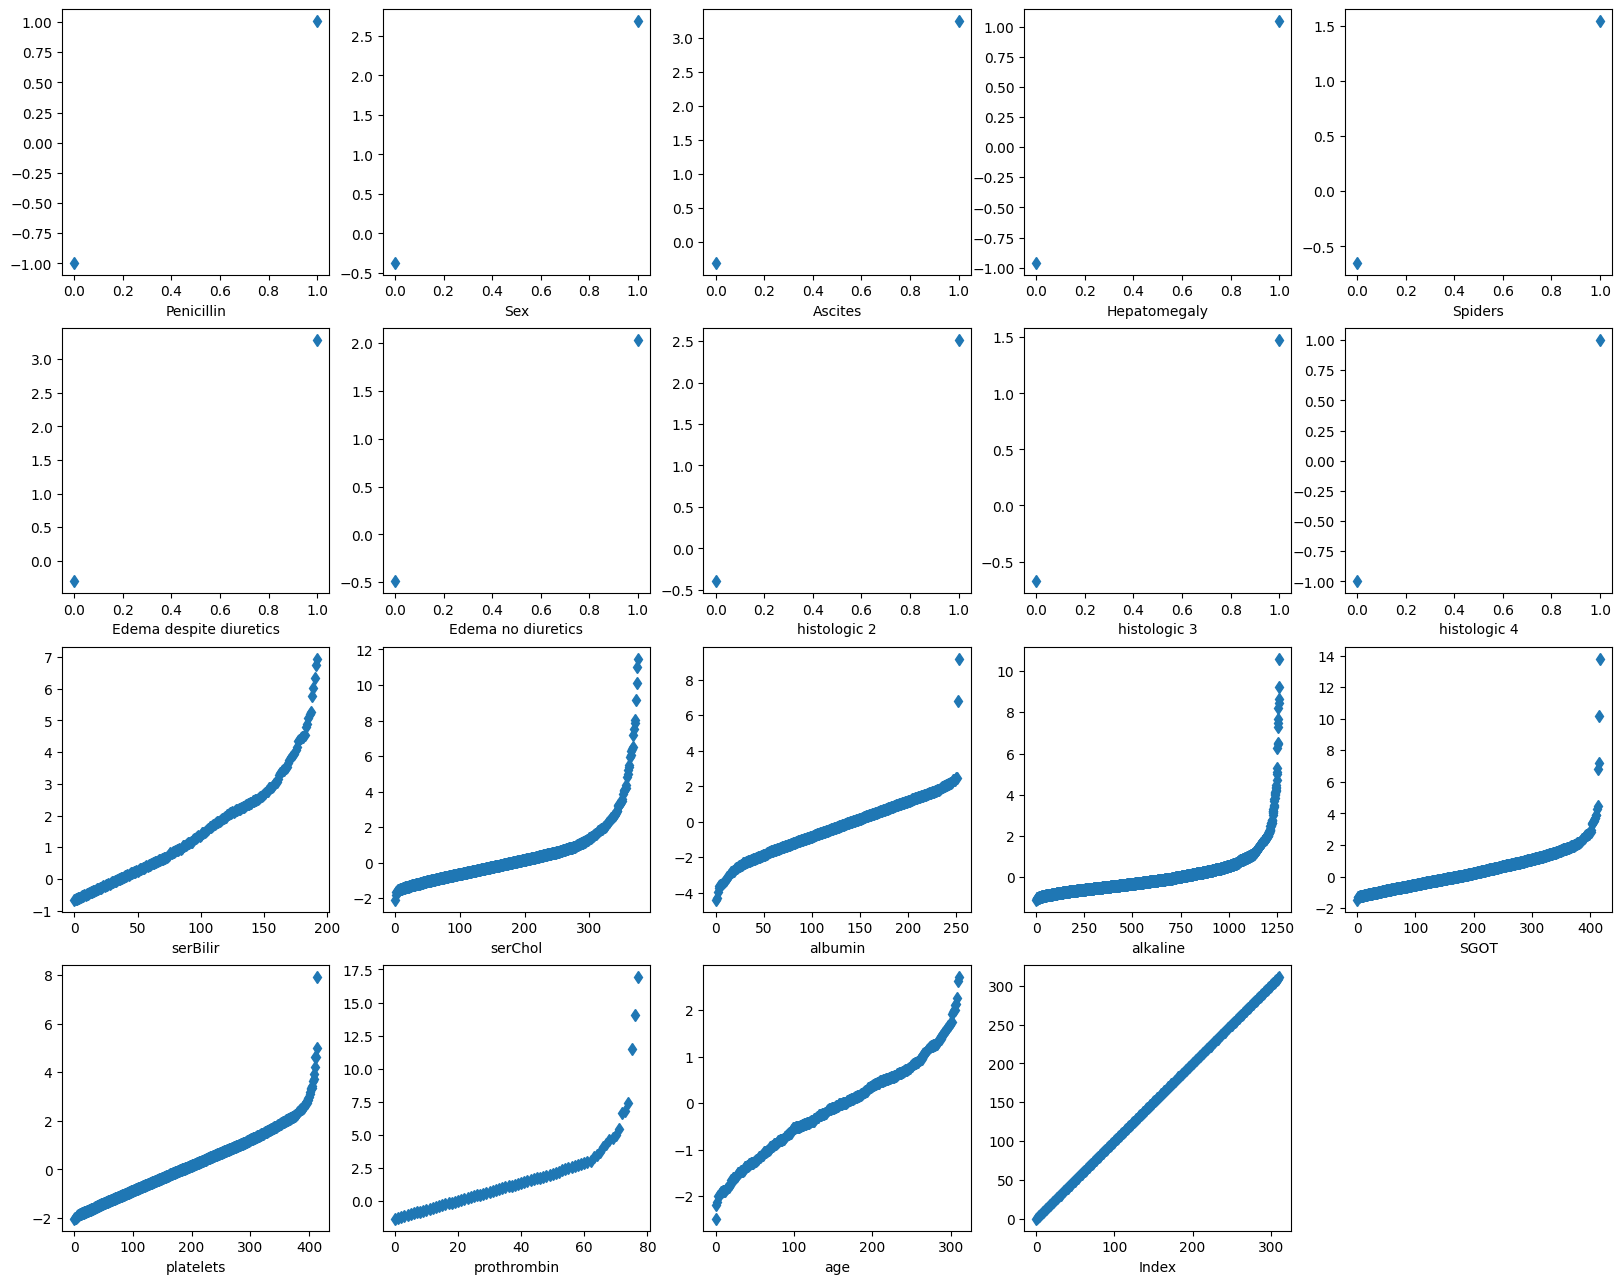

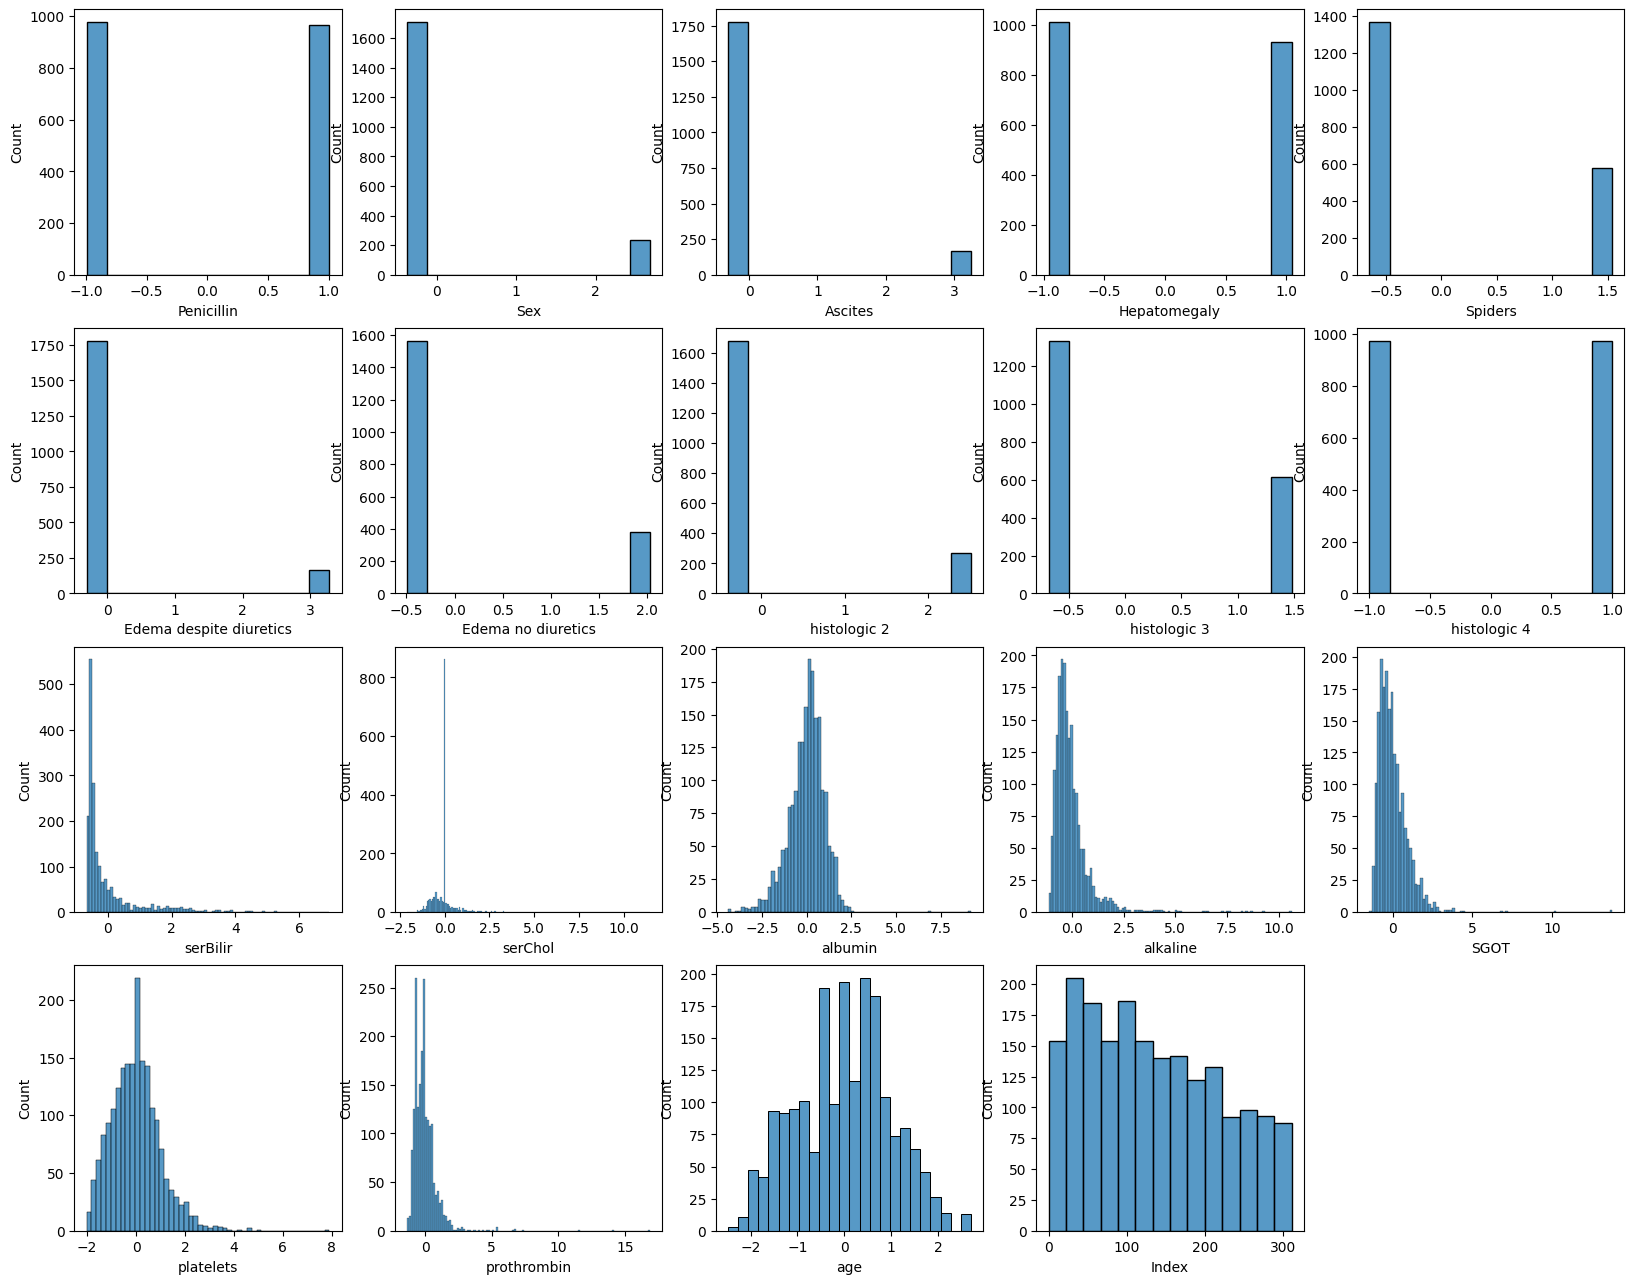

In [5]:
plt.figure(figsize=(20, 20))
for idp, k in enumerate(FlattenDataSet.keys()):
    plt.subplot(5, 5, idp+1)
    plt.plot(np.sort(FlattenDataSet[k].unique()),'d')
    plt.xlabel(k)
plt.tight_layout;

plt.figure(figsize=(20, 20))
for idp, k in enumerate(FlattenDataSet.keys()):
    plt.subplot(5, 5, idp+1)
    sns.histplot(FlattenDataSet[k])
    plt.xlabel(k)
plt.tight_layout;

In [6]:
# On calculera le brier score intégré avec les quantiles 0.25, 0.5, et 0.75
horizons = [0.25, 0.5, 0.75]
times = np.quantile(FlattenTime, horizons).tolist()


4.1 Faites quelques visualisations des temps avant événement sur le dataset. Un commentaire ?

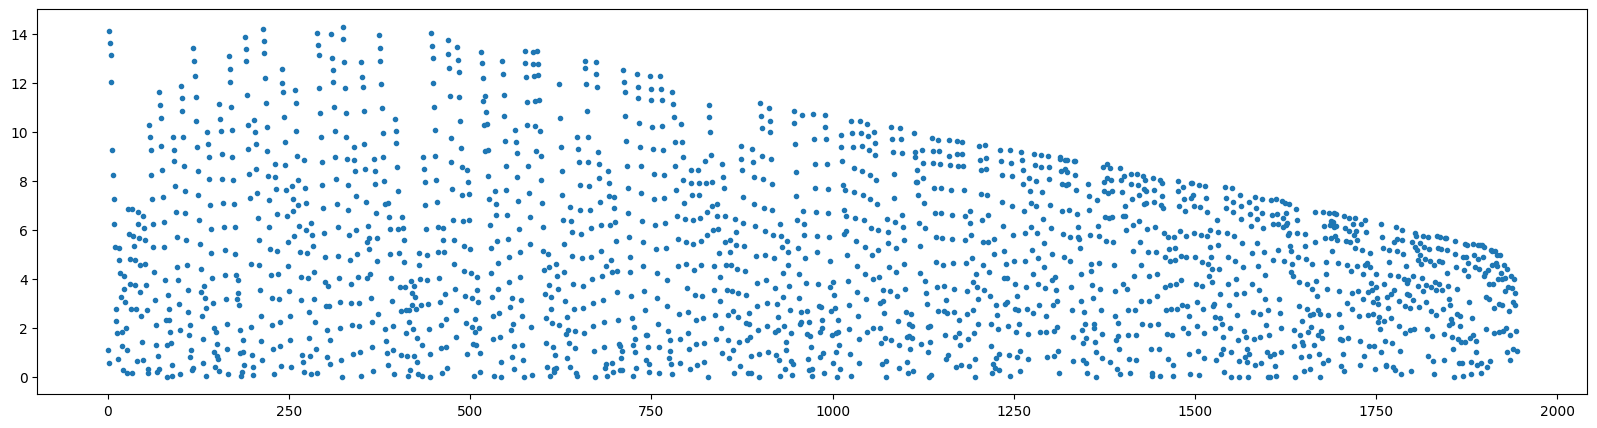

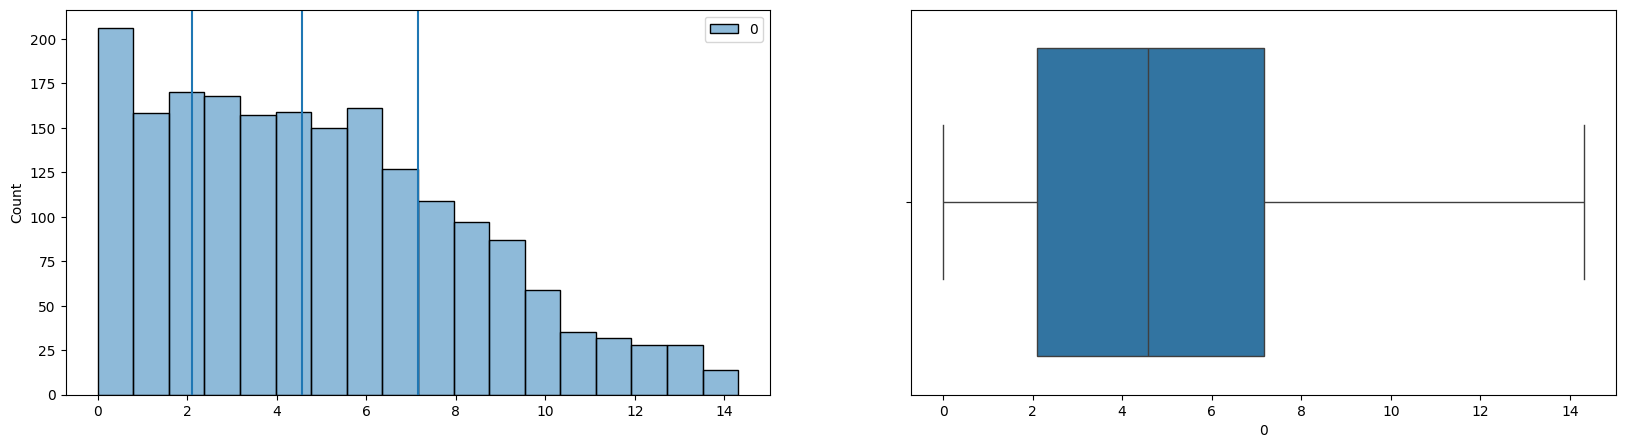

In [7]:
# Réponse
plt.figure(figsize=(20, 5))
plt.plot(FlattenTime, '.');
plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
sns.histplot(data=FlattenTime);
for value_t in times:
    plt.axvline(value_t)
plt.subplot(1,2, 2)
sns.boxplot(x=FlattenTime[0]);

4.2 Couper votre dataset en train / test / split.

In [8]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)
for train_index, test_index in gkf.split(x, groups=np.arange(len(x))):
    print("%s %s" % (len(train_index), len(test_index)))

#x_test = e_train, e_test, t_train, t_test = train_test_split(x, e, t, test_size=0.2, random_state=123)
x_train = np.array(x, dtype='object')[train_index]
x_test = np.array(x, dtype='object')[test_index]
e_train = np.array(e, dtype='object')[train_index]
e_test = np.array(e, dtype='object')[test_index]
t_train = np.array(t, dtype='object')[train_index]
t_test = np.array(t, dtype='object')[test_index]

208 104
208 104
208 104


4.3 Comparez deux architectures identiques entre lognormal & weibull.

In [9]:
from auton_survival.models.dsm import DeepRecurrentSurvivalMachines

In [10]:
param_setup_lognormal = {'k' : 3,
              'distribution' : 'LogNormal',
              'learning_rate' : 1e-3,
              'hidden': 100,
              'layers': 2,
              'typ': 'LSTM',
             }
param_setup_Weibull = {'k' : 3,
              'distribution' : 'Weibull',
              'learning_rate' : 1e-3,
              'hidden': 100,
              'layers': 2,
              'typ': 'LSTM',
             }

def learn(param):
    model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'],
                                 typ = param['typ'],
                                 layers = param['layers'])

    model.fit(x_train, t_train, e_train, iters=10, learning_rate = param['learning_rate']);
    return model

model_lognormal = learn(param_setup_lognormal)
model_weibull = learn(param_setup_Weibull)

100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


In [11]:
print('tested times:', times)
et_train = np.array([(e_train[i][j], t_train[i][j]) for i in range(len(e_train)) for j in range(len(e_train[i]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i][j], t_test[i][j]) for i in range(len(e_test)) for j in range(len(e_test[i]))],
                 dtype = [('e', bool), ('t', float)])
et_train_df = pd.DataFrame(et_train)
et_test_df = pd.DataFrame(et_test)
print('train t min', et_train_df['t'].min(), et_train_df['t'].max())
print('test t min', et_test_df['t'].min(), et_test_df['t'].max())

tested times: [2.1054648997918886, 4.5750739239951805, 7.159675829591502]
train t min 0.0027379257474500207 14.3056620304457
test t min 0.0027379257474500207 14.2153104807798


In [12]:
from sksurv.metrics import integrated_brier_score

def evaluate(model):
    out_survival = model.predict_survival(x_test, times)
    ibs = integrated_brier_score(et_train, et_test, out_survival, times)
    return ibs

In [13]:
print('LogNormal:', evaluate(model_lognormal))
print('Weibull:', evaluate(model_weibull))

LogNormal: 0.16614251082147727
Weibull: 0.15531369852350288
